# Calculation of the TOV for the mixed EOS: NSM

## Alexandra Semposki

### Date: 21 October 2024

This notebook calculates the TOV equations for given data from the EOS from Bayesian model mixing. It then compares the 20n0 and 40n0 cutoff cases, and plots them in comparison to the NICER and LIGO data in the M-R posterior.

In [38]:
# import packages
%load_ext autoreload
%autoreload 2

import corner
import pickle
import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

In [40]:
# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
display(df_insens)

df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')
display(df_maxmass)

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.543236,1.205749,97.068200,248.541197,10.730811,9.358211
1,1.482590,1.253115,19.677667,280.480973,8.186003,9.833989
2,1.541613,1.206940,31.524739,235.511540,9.149591,9.373914
3,1.562878,1.191476,49.572338,409.681755,9.951128,10.102846
4,1.656298,1.128266,27.441288,246.930128,9.602853,9.395534
...,...,...,...,...,...,...
2916,1.508332,1.232504,91.421409,229.584025,10.730333,9.901073
2917,1.602577,1.163587,59.820623,266.473512,10.058355,9.314710
2918,1.561251,1.192543,12.951990,234.310549,8.475787,9.328835
2919,1.476021,1.258401,126.699863,346.595638,10.741590,10.844589


,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.637296,1.140765,66.373870,723.523060,10.887391,11.097352
1,1.612825,1.156845,191.207304,1335.339873,12.402063,12.349246
2,1.563015,1.191614,200.526550,1156.272842,12.285450,12.501216
3,1.625307,1.148567,134.833116,1439.597356,12.141489,12.627265
4,1.625909,1.148243,177.099466,1428.281697,12.399686,12.426146
...,...,...,...,...,...,...
2391,1.456157,1.275411,271.138172,593.167994,11.771023,11.732749
2392,1.363036,1.361102,275.144868,277.559025,11.146219,11.146212
2393,1.547311,1.202998,308.382837,1352.958123,12.800400,12.770993
2394,1.379074,1.345569,253.244553,293.279550,11.077769,11.070750


In [41]:
# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

In [42]:
# load results from the NSM notebooks for pressure, energy density, speed of sound
with open('pres_data_20n0.pkl', 'rb') as fp:
    pressure_dict = pickle.load(fp)  # automatically in order of saving
    edens_dict = pickle.load(fp)
    cs2_dict = pickle.load(fp)
    
# using this one (oops...dammit)
with open('pres_data_mean_40n0.pkl', 'rb') as fp:
    pressure_dict_mean_40 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_40 = pickle.load(fp)
    cs2_dict_mean_40 = pickle.load(fp)
    
# and this one (oops again...ugh)
with open('pres_data_mean_20n0.pkl', 'rb') as fp:
    pressure_dict_mean_20 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_20 = pickle.load(fp)
    cs2_dict_mean_20 = pickle.load(fp)
    
# load in speed of sound results from sampling
cs2_samples_40 = np.load('../data/NSM_data/cs2_40n0.npz')
cs2_samples_20 = np.load('cs2_20n0.npz')

In [48]:
print(pressure_dict_mean_40['samples'].shape)
print(edens_dict_mean_40.shape)
print(cs2_dict_mean_40.shape)

print(pressure_dict_mean_20['samples'].shape)
print(edens_dict_mean_20.shape)
print(cs2_dict_mean_20.shape)

(899, 476)
(899, 476)
(899, 476)
(899, 461)
(899, 461)
(899, 461)


# 40 n0

In [44]:
# number of samples
samples = len(pressure_dict_mean_40['samples'].T)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_dict_mean_40.T, pressure_dict_mean_40, save=True, \
                    filepath='../data/TOV_data/eos_stationary_40n0.npz')

# call the solver once, send all data directly
tov = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_40n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_40, pressure_data_40, mass_data_40 = tov.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  10.850150079199999 Maximum mass:  1.7407552984462822 Central pressure:  342.0973067434033
Radius:  10.7697413864 Maximum mass:  1.2191570770829088 Central pressure:  157.510626754264
Radius:  11.0913761576 Maximum mass:  1.6723967134390694 Central pressure:  292.9420362292324
Radius:  8.7059182712 Maximum mass:  1.2900385870421147 Central pressure:  544.8206153354404
Radius:  8.9605457984 Maximum mass:  1.2875210407083744 Central pressure:  544.8206153354404
Radius:  9.5502095456 Maximum mass:  1.4632766290863248 Central pressure:  466.5364423805275
Radius:  10.314092127199999 Maximum mass:  1.5327861009513526 Central pressure:  342.0973067434033
Radius:  10.1800776392 Maximum mass:  1.4050923127143915 Central pressure:  292.9420362292324
Radius:  8.786326963999999 Maximum mass:  1.2391542105511424 Central pressure:  544.8206153354404
Radius:  8.8131298616 Maximum mass:  1.4065472030881279 Central pressure:  544.8206153354404
Radius:  10.2470848832 Maximum mass:

Radius:  9.871844316799999 Maximum mass:  1.6466582937385772 Central pressure:  544.8206153354404
Radius:  6.776109644 Maximum mass:  0.9361250235877838 Central pressure:  1183.2958131473647
Radius:  9.630618238399999 Maximum mass:  1.4892840255262658 Central pressure:  466.5364423805275
Radius:  8.8667356568 Maximum mass:  1.249197054518361 Central pressure:  466.5364423805275
Radius:  5.824606779200001 Maximum mass:  0.9791756557614057 Central pressure:  1613.7239553412246
Radius:  7.3523719424000005 Maximum mass:  1.1498181754858376 Central pressure:  1013.2704295883759
Radius:  11.332602236 Maximum mass:  1.7623743517589747 Central pressure:  292.9420362292324
Radius:  12.927374643199999 Maximum mass:  2.1971199804023285 Central pressure:  250.84978717618554
Radius:  7.8616269968 Maximum mass:  1.1105880295940567 Central pressure:  743.0010894672662
Radius:  9.7512312776 Maximum mass:  1.3199826860946937 Central pressure:  292.9420362292324
Radius:  6.1864458968000005 Maximum mass:

Radius:  9.188370427999999 Maximum mass:  1.4074914744982427 Central pressure:  544.8206153354404
Radius:  8.451290744 Maximum mass:  1.1730356813976206 Central pressure:  544.8206153354404
Radius:  12.337710895999999 Maximum mass:  2.1980136396617036 Central pressure:  342.0973067434033
Radius:  8.7461226176 Maximum mass:  1.3086124045804097 Central pressure:  544.8206153354404
Radius:  9.4429979552 Maximum mass:  1.5926118433097345 Central pressure:  544.8206153354404
Radius:  10.6223254496 Maximum mass:  1.4102920380759945 Central pressure:  250.84978717618554
Radius:  8.8667356568 Maximum mass:  1.3760959962269237 Central pressure:  636.240764772628
Radius:  8.9471443496 Maximum mass:  1.3458150521676444 Central pressure:  544.8206153354404
Radius:  6.8565183368 Maximum mass:  1.0187218291875575 Central pressure:  1183.2958131473647
Radius:  9.5502095456 Maximum mass:  1.523574657978414 Central pressure:  466.5364423805275
Radius:  11.131580504 Maximum mass:  1.9157718467549187 Cen

Radius:  12.2439007544 Maximum mass:  2.1283344694832746 Central pressure:  342.0973067434033
Radius:  8.3842835 Maximum mass:  1.203692606675534 Central pressure:  636.240764772628
Radius:  6.3338618336 Maximum mass:  0.9747571184830164 Central pressure:  1381.8512220680184
Radius:  5.8648111256 Maximum mass:  0.8781703251236096 Central pressure:  1613.7239553412246
Radius:  11.332602236 Maximum mass:  1.8639943488043946 Central pressure:  342.0973067434033
Radius:  9.8182385216 Maximum mass:  1.1920501711233489 Central pressure:  250.84978717618554
Radius:  10.4883109616 Maximum mass:  1.5775341579746347 Central pressure:  342.0973067434033
Radius:  12.029477573600001 Maximum mass:  1.9802705073057616 Central pressure:  292.9420362292324
Radius:  11.8954630856 Maximum mass:  2.1580766125238933 Central pressure:  399.5007639993038
Radius:  10.4481066152 Maximum mass:  1.3200908040040265 Central pressure:  183.94069314768447
Radius:  12.203696408 Maximum mass:  2.026704964258661 Centra

Radius:  8.1028530752 Maximum mass:  1.1546799309361595 Central pressure:  636.240764772628
Radius:  10.1130703952 Maximum mass:  1.6167050472654518 Central pressure:  466.5364423805275
Radius:  5.141132890400001 Maximum mass:  0.8212230909569399 Central pressure:  2200.721894819905
Radius:  9.469800852799999 Maximum mass:  1.4977033423672863 Central pressure:  466.5364423805275
Radius:  11.4934196216 Maximum mass:  1.9524994841363497 Central pressure:  342.0973067434033
Radius:  8.062648728800001 Maximum mass:  1.2781372116259944 Central pressure:  743.0010894672662
Radius:  8.0090429336 Maximum mass:  1.2160169009752442 Central pressure:  743.0010894672662
Radius:  8.5987066808 Maximum mass:  1.3101878490121666 Central pressure:  636.240764772628
Radius:  9.7780341752 Maximum mass:  1.3049314279566069 Central pressure:  292.9420362292324
Radius:  6.039029960000001 Maximum mass:  0.8977897520492018 Central pressure:  1613.7239553412246
Radius:  13.0479876824 Maximum mass:  2.203133429

Radius:  9.6976254824 Maximum mass:  1.4346441086302422 Central pressure:  399.5007639993038
Radius:  16.5323643704 Maximum mass:  3.1962616627029394 Central pressure:  214.8056883072157
Radius:  11.6140326608 Maximum mass:  1.8118834772591108 Central pressure:  250.84978717618554
Radius:  9.0677573888 Maximum mass:  1.3132544081891417 Central pressure:  466.5364423805275
Radius:  7.258561800800001 Maximum mass:  1.08085398120024 Central pressure:  1013.2704295883759
Radius:  7.7678168552 Maximum mass:  1.0784291884810435 Central pressure:  743.0010894672662
Radius:  9.791435623999998 Maximum mass:  1.4680479409168785 Central pressure:  399.5007639993038
Radius:  11.077974708800001 Maximum mass:  1.6137461256773724 Central pressure:  250.84978717618554
Radius:  11.171784850399998 Maximum mass:  1.5983542736423564 Central pressure:  214.8056883072157
Radius:  10.6491283472 Maximum mass:  1.7228883570813496 Central pressure:  342.0973067434033
Radius:  9.737829828799999 Maximum mass:  1.

In [45]:
# save these results (and do not ever run again)
np.savez('../data/TOV_data/tov_results_40n0_stationaryRBF.npz', density=pressure_dict_mean_40['dens'], \
         radius=radius_data_40, mass=mass_data_40, central_pressure=pressure_data_40)

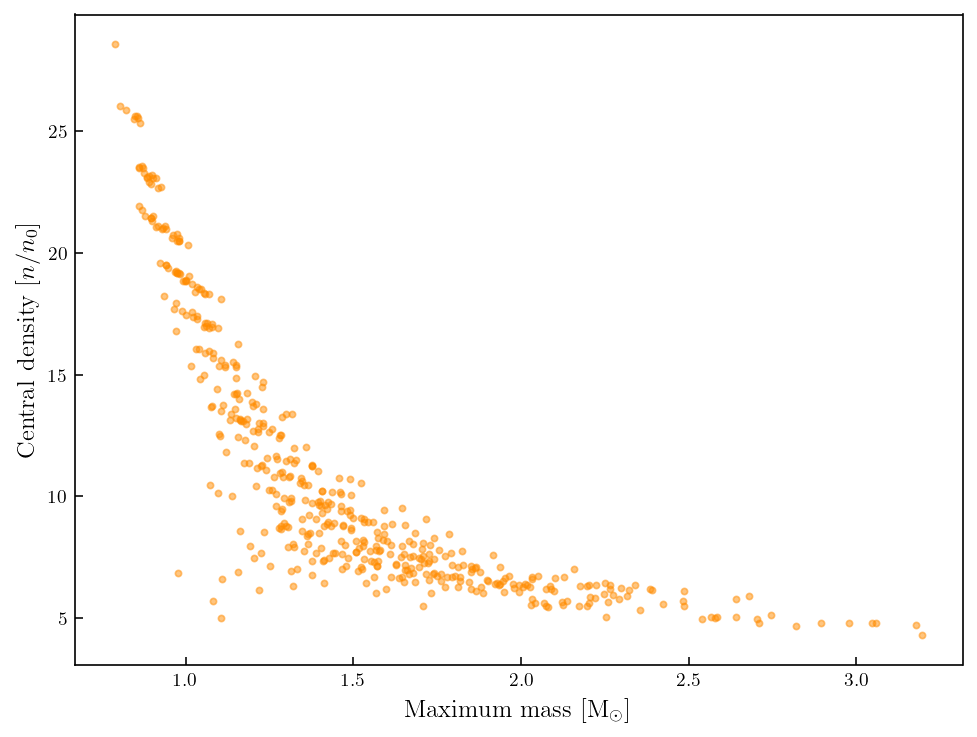

In [47]:
cdens_40n0 = tov.central_dens()
max_mass_40n0 = tov.max_mass_arr
# plot the maximum mass vs. central density
plt.scatter(max_mass_40n0, cdens_40n0/n0, marker='.', color='darkorange', alpha=0.5)
plt.ylabel(r'Central density [$n/n_{0}]$', fontsize=12)
plt.xlabel(r'Maximum mass [M$_\odot$]', fontsize=12)
plt.show()

In [50]:
# marginalize over max mass using Simpsons?
from scipy.integrate import simps

## JUST RUN THE GODDAMN TOV CODE AGAIN!!!

# 20 n0

In [49]:
# number of samples
samples = len(pressure_dict_mean_20['samples'].T)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_dict_mean_20.T, pressure_dict_mean_20, save=True, \
                    filepath='../data/TOV_data/eos_stationary_20n0.npz')

# call the solver once, send all data directly
tov20n0 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_20n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_20, pressure_data_20, mass_data_20 = tov20n0.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  7.137948761600001 Maximum mass:  1.1672801323055118 Central pressure:  1183.2958131473647
Radius:  9.094560286399998 Maximum mass:  1.5992551372286494 Central pressure:  743.0010894672662
Radius:  13.168600721599999 Maximum mass:  2.4760182477407944 Central pressure:  342.0973067434033
Radius:  9.7512312776 Maximum mass:  1.6434008533536368 Central pressure:  544.8206153354404
Radius:  9.7110269312 Maximum mass:  1.6061696719157041 Central pressure:  544.8206153354404
Radius:  11.868660188 Maximum mass:  2.246617174431136 Central pressure:  466.5364423805275
Radius:  12.2573022032 Maximum mass:  2.283446729599475 Central pressure:  399.5007639993038
Radius:  11.8820616368 Maximum mass:  1.9234982017278 Central pressure:  292.9420362292324
Radius:  13.168600721599999 Maximum mass:  2.2237374906142 Central pressure:  250.84978717618554
Radius:  11.8284558416 Maximum mass:  2.166271431726674 Central pressure:  399.5007639993038
Radius:  11.600631212000001 Maximum m

Radius:  11.9892732272 Maximum mass:  2.051857885607562 Central pressure:  342.0973067434033
Radius:  11.0377703624 Maximum mass:  1.7527462007758268 Central pressure:  342.0973067434033
Radius:  9.5636109944 Maximum mass:  1.5623275302293789 Central pressure:  544.8206153354404
Radius:  14.5891542944 Maximum mass:  2.81824956381631 Central pressure:  292.9420362292324
Radius:  7.178153108 Maximum mass:  1.1812672154520587 Central pressure:  1013.2704295883759
Radius:  7.754415406400001 Maximum mass:  1.2966551265712618 Central pressure:  867.6756497154504
Radius:  12.726352911200001 Maximum mass:  2.2641337613151693 Central pressure:  342.0973067434033
Radius:  13.986089098399999 Maximum mass:  2.6242954526057187 Central pressure:  292.9420362292324
Radius:  10.2872892296 Maximum mass:  1.6929701362085807 Central pressure:  466.5364423805275
Radius:  8.2368675632 Maximum mass:  1.4706958748846743 Central pressure:  743.0010894672662
Radius:  12.9541775408 Maximum mass:  2.395335560256

Radius:  11.3594051336 Maximum mass:  1.8456108636234199 Central pressure:  342.0973067434033
Radius:  12.538732628 Maximum mass:  1.7894119341530652 Central pressure:  157.510626754264
Radius:  14.7633731288 Maximum mass:  2.978422071775873 Central pressure:  342.0973067434033
Radius:  9.898647214399999 Maximum mass:  1.621975873014615 Central pressure:  466.5364423805275
Radius:  9.724428379999999 Maximum mass:  1.5076418649356287 Central pressure:  544.8206153354404
Radius:  10.5553182056 Maximum mass:  1.8721619814917694 Central pressure:  544.8206153354404
Radius:  17.0550208736 Maximum mass:  3.340079062429411 Central pressure:  214.8056883072157
Radius:  11.868660188 Maximum mass:  1.777909089960481 Central pressure:  250.84978717618554
Radius:  6.8297154392 Maximum mass:  1.201417656572651 Central pressure:  1183.2958131473647
Radius:  8.585305232 Maximum mass:  1.332604758555779 Central pressure:  743.0010894672662
Radius:  11.372806582399999 Maximum mass:  1.8790089565314843 

Radius:  6.8565183368 Maximum mass:  1.1356235066534368 Central pressure:  1183.2958131473647
Radius:  13.1283963752 Maximum mass:  2.1693126653492745 Central pressure:  250.84978717618554
Radius:  14.106702137600001 Maximum mass:  2.4206008443524416 Central pressure:  214.8056883072157
Radius:  15.5004528128 Maximum mass:  2.7286081159945588 Central pressure:  183.94069314768447
Radius:  11.8418572904 Maximum mass:  2.0183270377966274 Central pressure:  342.0973067434033
Radius:  9.4832023016 Maximum mass:  1.633270164524653 Central pressure:  636.240764772628
Radius:  9.5100051992 Maximum mass:  1.6517808351445962 Central pressure:  636.240764772628
Radius:  6.9503284784 Maximum mass:  1.1784501203829485 Central pressure:  1183.2958131473647
Radius:  13.088192028799998 Maximum mass:  2.097940283885484 Central pressure:  214.8056883072157
Radius:  13.811870264 Maximum mass:  2.5402445974341528 Central pressure:  292.9420362292324
Radius:  9.2687791208 Maximum mass:  1.4606237803972186

Radius:  11.131580504 Maximum mass:  1.9029348045126966 Central pressure:  399.5007639993038
Radius:  11.104777606399999 Maximum mass:  2.020351119949752 Central pressure:  466.5364423805275
Radius:  10.461508064 Maximum mass:  1.824024995824355 Central pressure:  544.8206153354404
Radius:  8.1430574216 Maximum mass:  1.4706262057937296 Central pressure:  867.6756497154504
Radius:  11.3460036848 Maximum mass:  2.030031152733605 Central pressure:  399.5007639993038
Radius:  10.0326617024 Maximum mass:  1.7283698117975912 Central pressure:  544.8206153354404
Radius:  8.9069400032 Maximum mass:  1.4302868993591575 Central pressure:  636.240764772628
Radius:  13.838673161600001 Maximum mass:  2.694850531054442 Central pressure:  342.0973067434033
Radius:  7.4863864304000005 Maximum mass:  1.2853344276229413 Central pressure:  1013.2704295883759
Radius:  9.9120486632 Maximum mass:  1.6988933744946169 Central pressure:  544.8206153354404
Radius:  8.7595240664 Maximum mass:  1.520552427679954

Radius:  10.3006906784 Maximum mass:  1.7217267237187208 Central pressure:  466.5364423805275
Radius:  7.3523719424000005 Maximum mass:  1.1069407446635675 Central pressure:  1013.2704295883759
Radius:  11.707842802399998 Maximum mass:  1.9301968513627694 Central pressure:  342.0973067434033
Radius:  13.3160166584 Maximum mass:  2.365221811986068 Central pressure:  292.9420362292324
Radius:  7.580196572000001 Maximum mass:  1.2376949903499728 Central pressure:  1013.2704295883759
Radius:  10.0862674976 Maximum mass:  1.711206680501748 Central pressure:  544.8206153354404
Radius:  7.7008096112 Maximum mass:  1.3045408254361948 Central pressure:  867.6756497154504
Radius:  10.2872892296 Maximum mass:  1.5972277629337253 Central pressure:  399.5007639993038
Radius:  11.9088645344 Maximum mass:  2.1327397695789436 Central pressure:  399.5007639993038
Radius:  11.3057993384 Maximum mass:  2.0669750181146473 Central pressure:  466.5364423805275
Radius:  11.9758717784 Maximum mass:  1.8884383

In [51]:
# save these results (and do not ever run again)
np.savez('../data/TOV_data/tov_results_20n0_stationaryRBF.npz', density=pressure_dict_mean_20['dens'], \
         radius=radius_data_20, mass=mass_data_20, central_pressure=pressure_data_20)

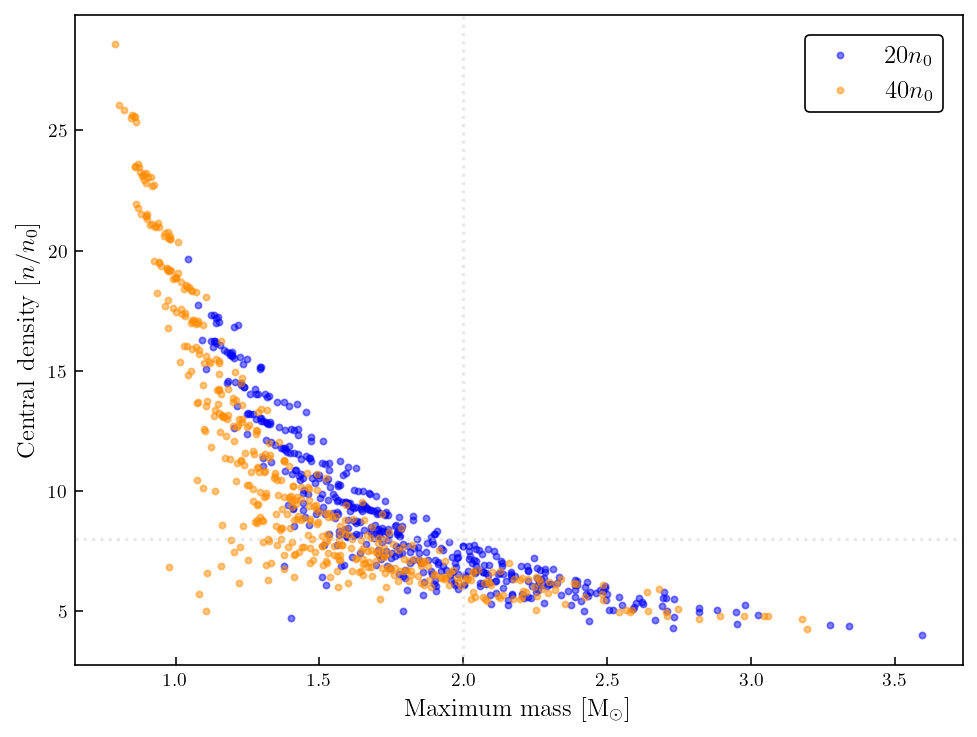

In [56]:
cdens_20n0_real = tov20n0.central_dens()
max_mass_20n0_real = tov20n0.max_mass_arr
# plot the maximum mass vs. central density
plt.scatter(max_mass_20n0_real, cdens_20n0_real/n0, marker='.', color='blue', alpha=0.5, label=r'$20n_0$')
plt.scatter(max_mass_40n0, cdens_40n0/n0, marker='.', color='darkorange', alpha=0.5, label=r'$40n_0$')
plt.axhline(y=8.0, linestyle='dotted', color='lightgray', alpha=0.5)
plt.axvline(x=2.0, linestyle='dotted', color='lightgray', alpha=0.5)
plt.ylabel(r'Central density [$n/n_{0}]$', fontsize=12)
plt.xlabel(r'Maximum mass [M$_\odot$]', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('central_densities.png')
plt.show()

In [141]:
# exclude the points with less than 2.0 maximum mass and compare in histogram below
ind_20 = []
ind_40 = []
for i in range(len(max_mass_20n0_real)):
    if max_mass_20n0_real[i] < 2.0:
        ind_20.append(i)
for j in range(len(max_mass_40n0)):
    if max_mass_40n0[j] < 2.0:
        ind_40.append(j)

In [178]:
# delete the central densities that we don't want to keep
cdens_20_reduced = np.delete(cdens_20n0_real, ind_20)
cdens_40_reduced = np.delete(cdens_40n0, ind_40)

## Histogram (all stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/142379428.py:55: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


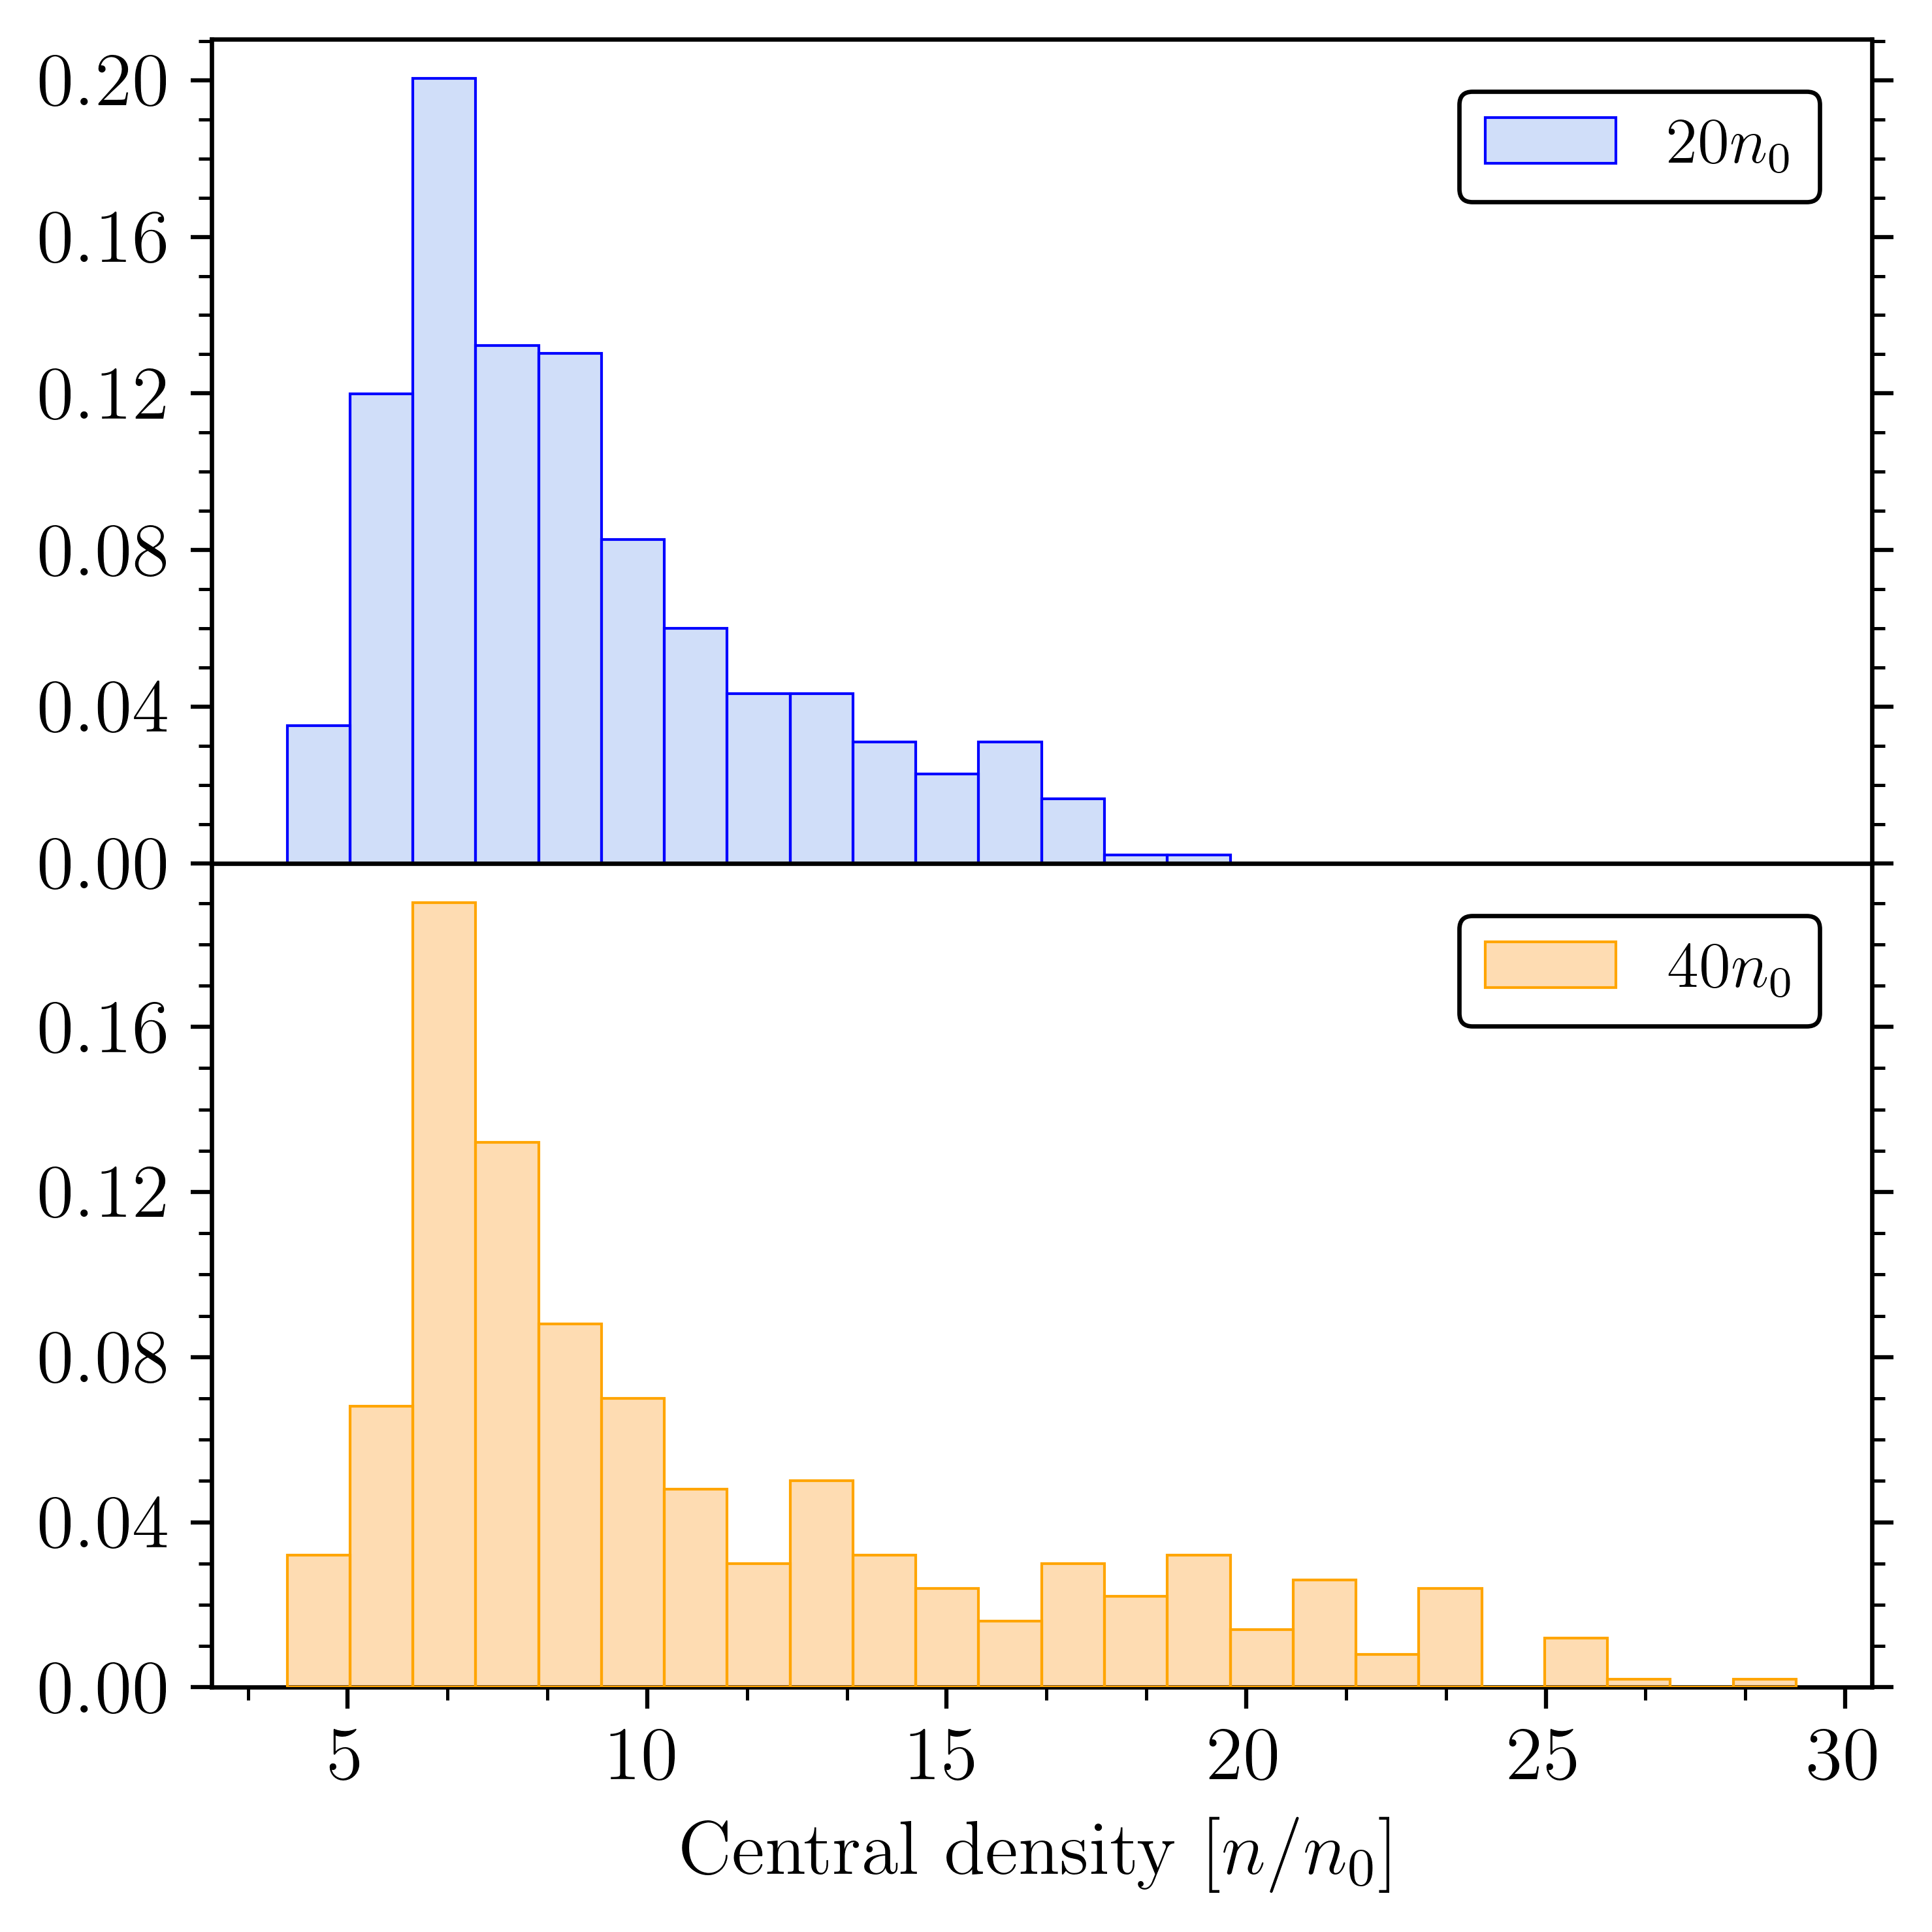

In [207]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True, )
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.04))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.04))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))

cdens_scaled = cdens_20n0_real/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/1171273035.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


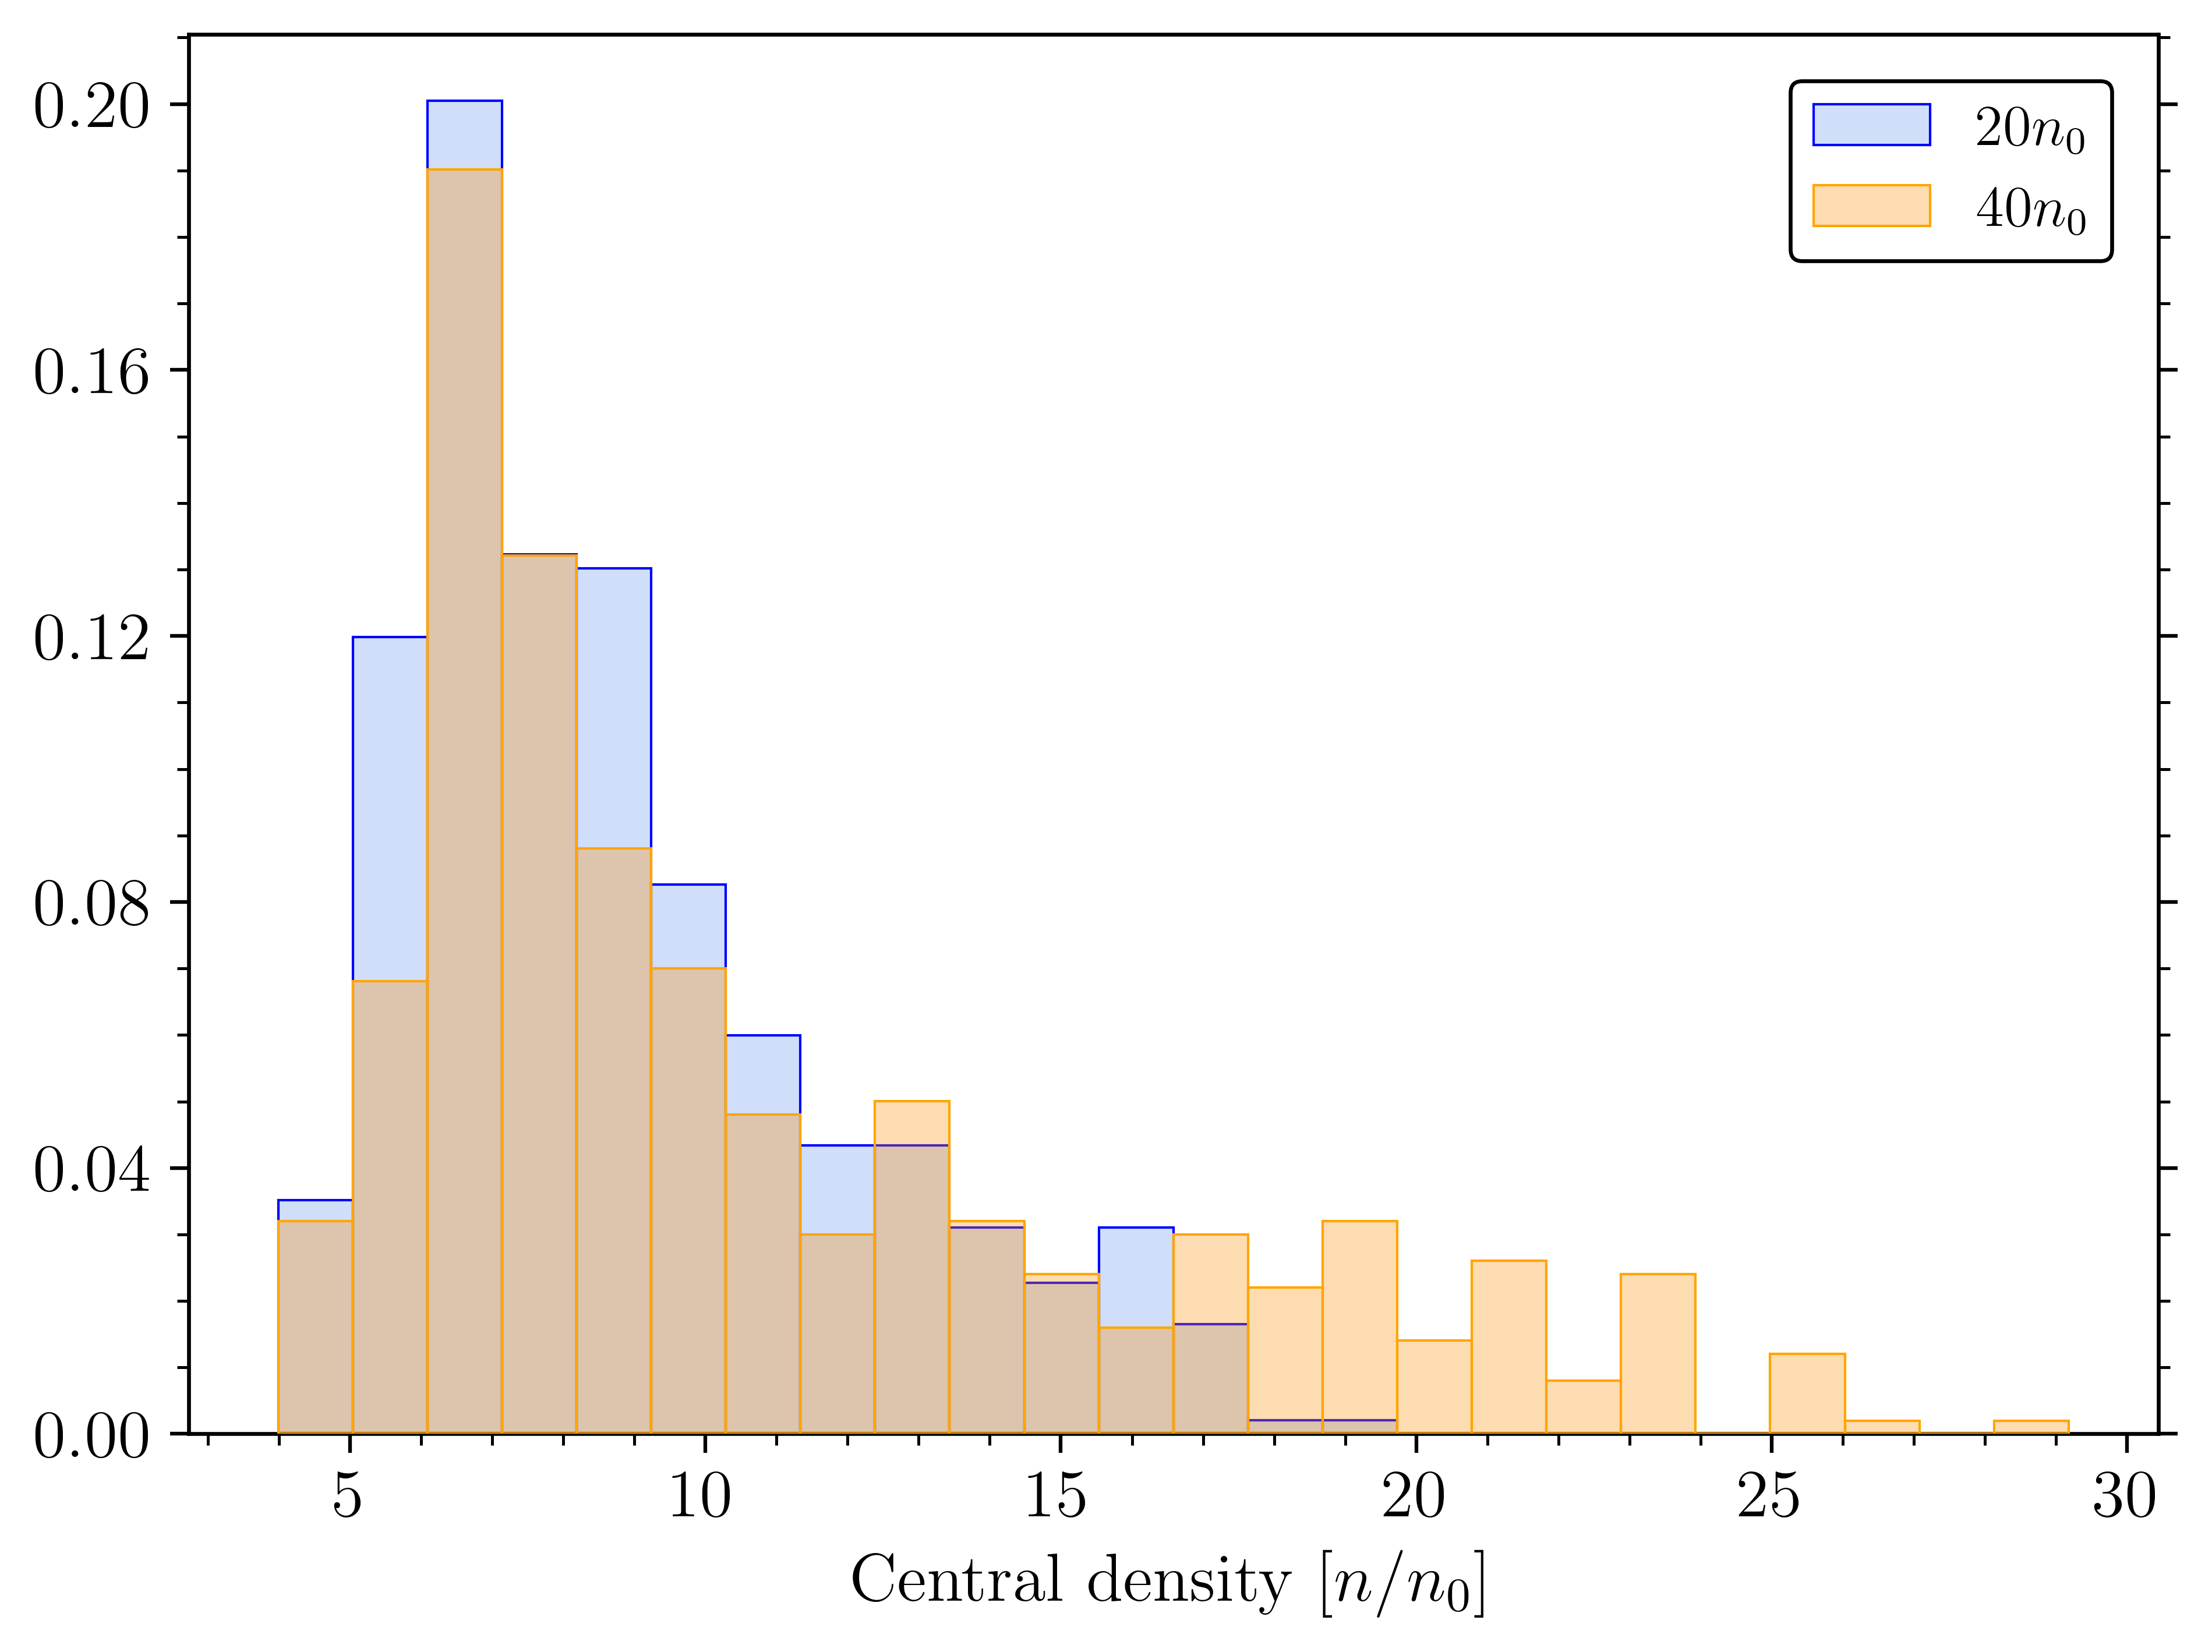

In [211]:
# histogram all on one plot from above
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

cdens_scaled = cdens_20n0_real/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_one_plot.png')
plt.show()

In [173]:
max_rad20, max_cpres20, max_mass20 = tov20n0.max_arrays()
max_rad40, max_cpres40, max_mass40 = tov.max_arrays()

In [176]:
# save these central densities before you lose your mind
np.savez('cdens_20n0.npz', max_rad=max_rad20, max_cpres=max_cpres20, \
         max_mass=max_mass20, cdens=cdens_20n0_real)

np.savez('rpm_20n0.npz', rad=radius_data_20, cpres=pressure_data_20, mass=mass_data_20)

In [177]:
# save now the 40n0 stuff just in case
np.savez('cdens_40n0.npz', max_rad=max_rad40, max_cpres=max_cpres40, \
         max_mass=max_mass40, cdens=cdens_40n0)

np.savez('rpm_40n0.npz', rad=radius_data_40, cpres=pressure_data_40, mass=mass_data_40)

## Histogram (reduced stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/1360433307.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


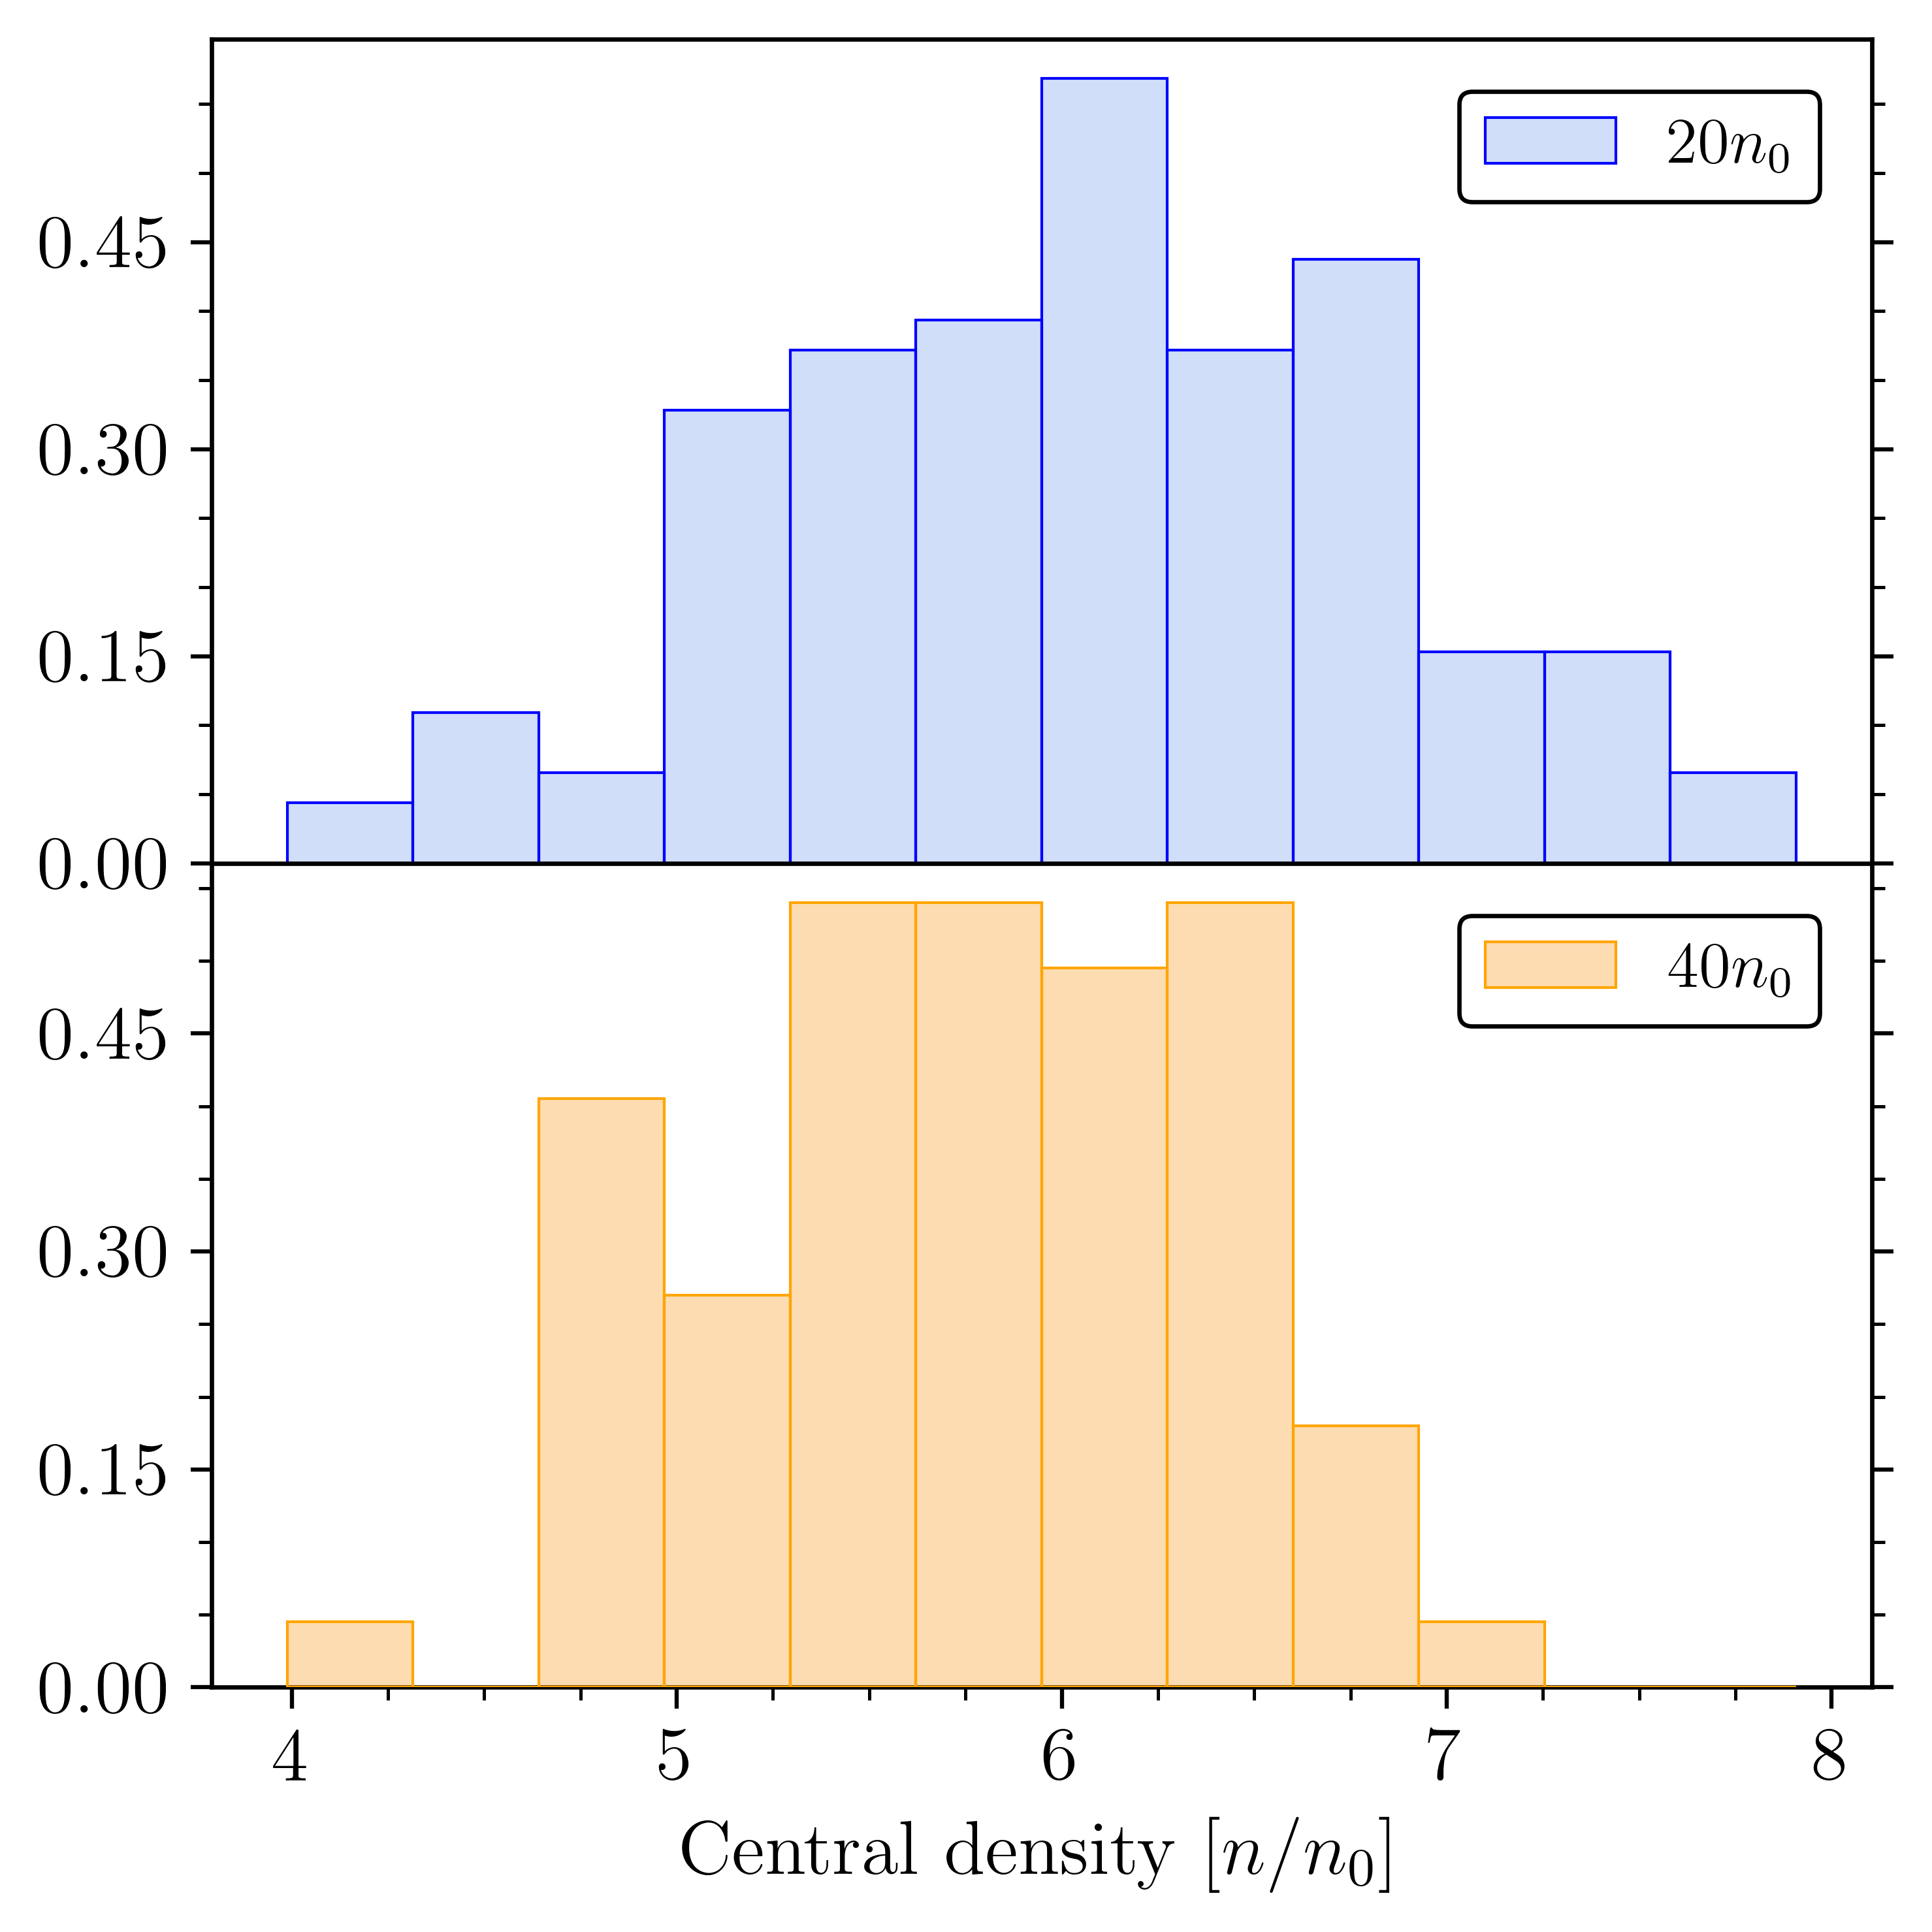

In [213]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True, )
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.15))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.15))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# consistent binning
def freedman_diaconis_bin_width(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    return 2 * iqr / np.cbrt(len(data))

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/4064960880.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


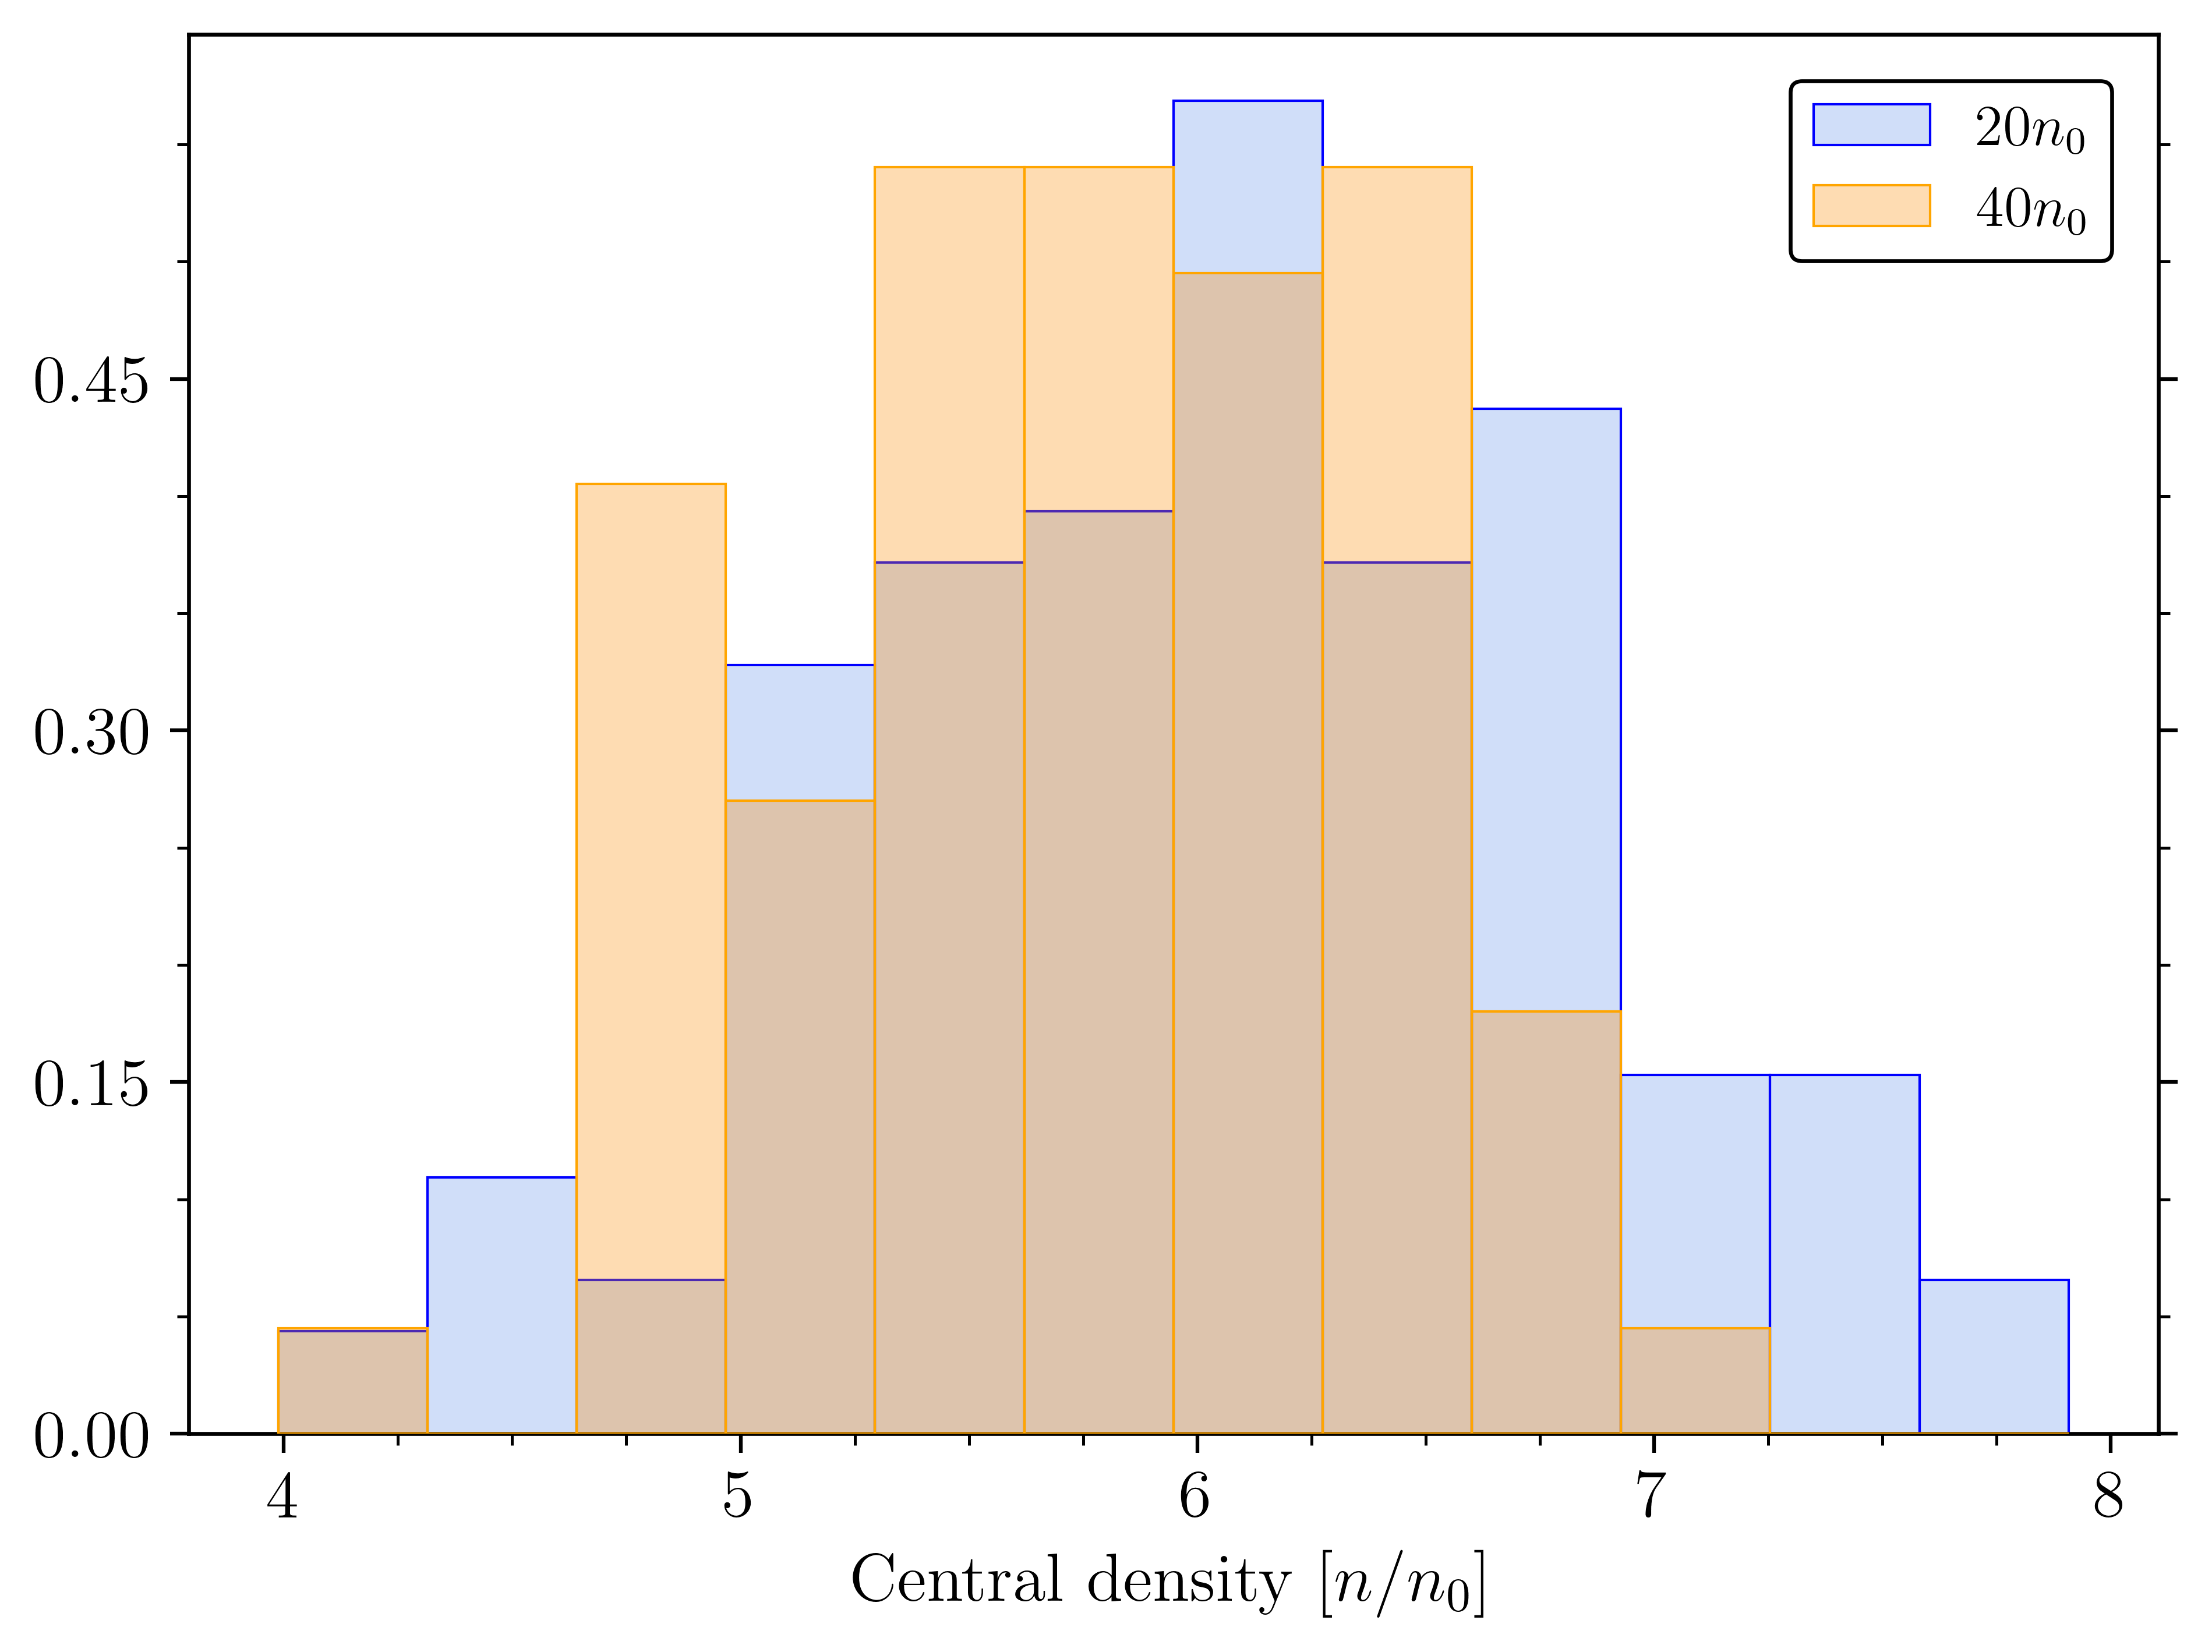

In [214]:
# combine back into one single plot
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.15))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced_one_plot.png')
plt.show()

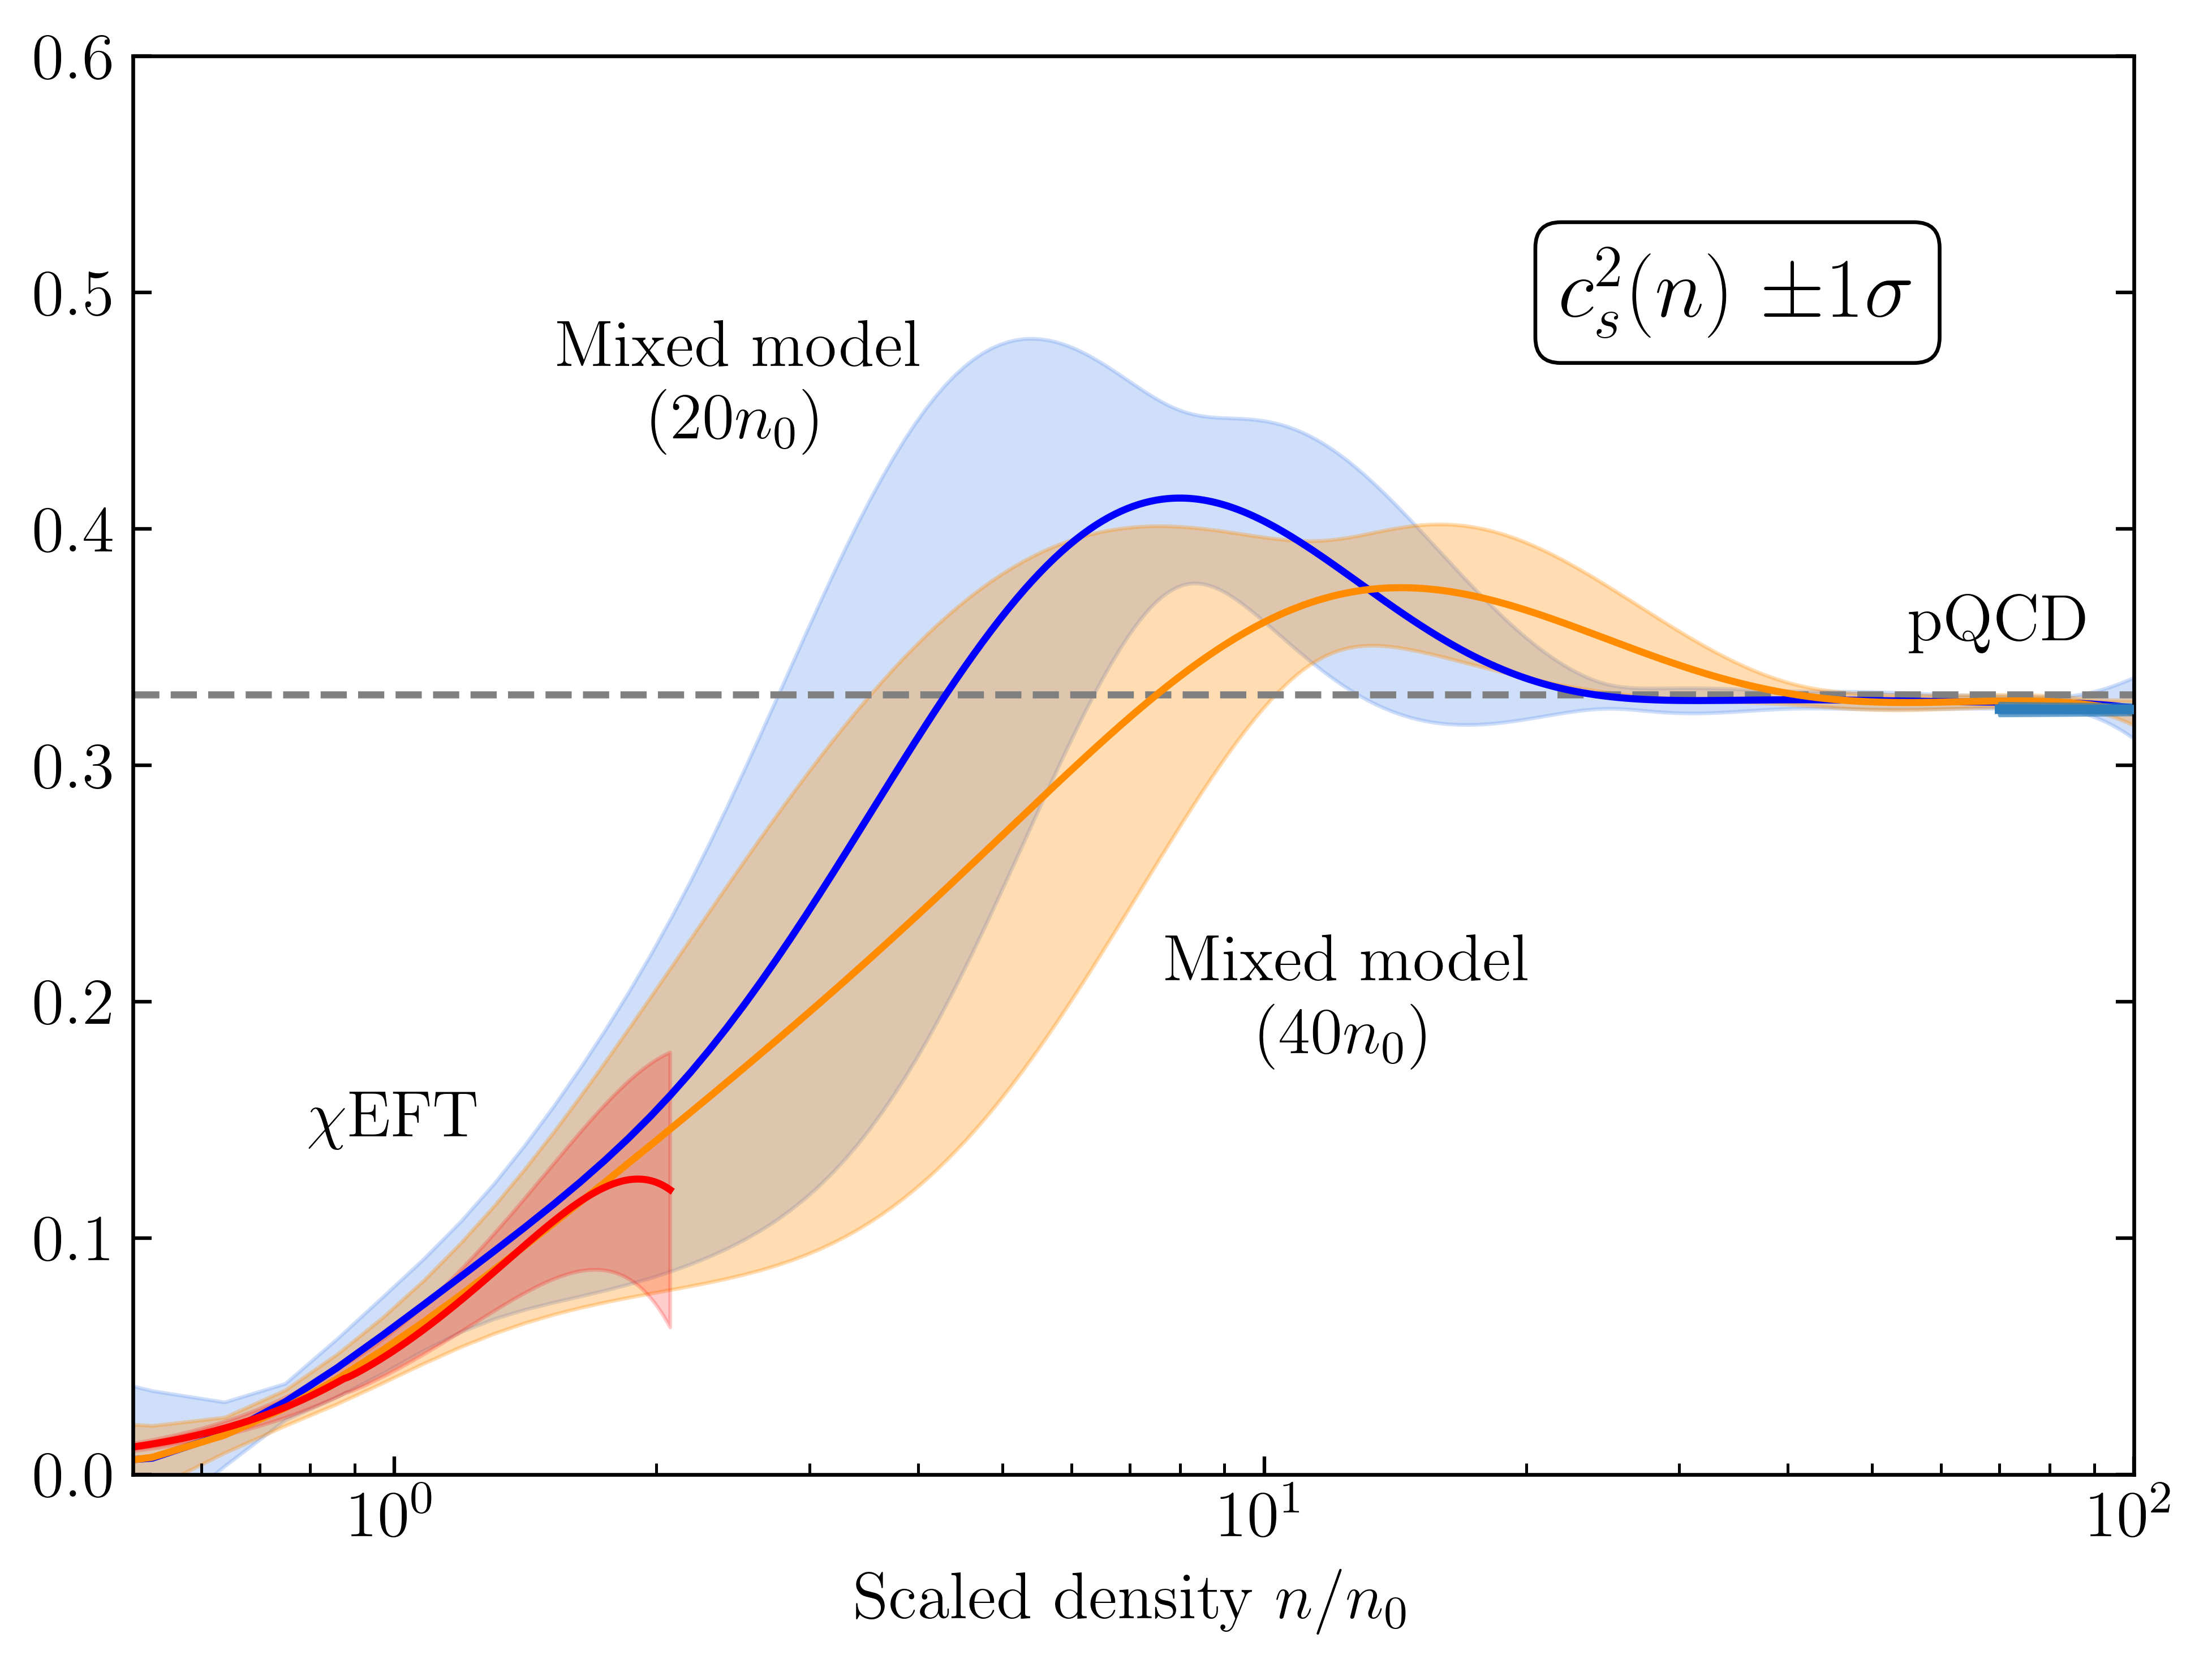

In [6]:
# speed of sound plot
plt.figure(dpi=600)
plt.tick_params(axis='both', which='major', labelsize=14, right=True)
plt.tick_params(axis='both', which='minor', labelsize=14, right=True)
pqcd_20 = np.load('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz')
pqcd_40 = np.load('../data/NSM_data/pressure_pqcd_cut_40_NSM.npz')
pressure_20 = np.load('../data/NSM_data/gp_pressure_20_NSM.npz')
pressure_40 = np.load('../data/NSM_data/gp_pressure_40_NSM.npz')
data_20 = np.load('../data/NSM_data/correlated_training_data_20n0_NSM.npz')
data_40 = np.load('../data/NSM_data/correlated_training_data_40n0_NSM.npz')
cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')

plt.axhline(y=0.33, linestyle='dashed', color='gray')

# speed of sound plotting
plt.plot(cs2_samples_20['dens'], cs2_samples_20['mean'], color='blue')
plt.fill_between(cs2_samples_20['dens'], cs2_samples_20['mean']-cs2_samples_20['std'], \
                 cs2_samples_20['mean']+cs2_samples_20['std'], color='cornflowerblue', alpha=0.3)

plt.plot(cs2_samples_40['dens'], cs2_samples_40['mean'], color='darkorange')
plt.fill_between(cs2_samples_40['dens'], cs2_samples_40['mean']-cs2_samples_40['std'], \
                 cs2_samples_40['mean']+cs2_samples_40['std'], color='darkorange', alpha=0.3)

plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

plt.plot(cs2_chiral['density']/n0, cs2_chiral['mean'], color='red', label=r'ChEFT (N3LO)')
plt.fill_between(cs2_chiral['density']/n0, cs2_chiral['mean']-cs2_chiral['std'], \
                 cs2_chiral['mean']+cs2_chiral['std'], alpha=0.2, \
                color='red')

plt.text(35.0, 0.5, r'$c_{s}^{2}(n)$ $\pm 1\sigma$', va='center', ha='center', \
         fontsize=18, bbox=dict(facecolor='w', boxstyle='round'))
plt.text(70.0, 0.36, r'''pQCD''', va='center', ha='center', fontsize=14)
plt.text(1.0, 0.15, r'''$\chi$EFT''', va='center', ha='center', fontsize=14)
plt.text(2.5, 0.46, r'''Mixed model 
($20n_0$)''', va='center', ha='center', fontsize=14)
plt.text(12.5, 0.2, r'''Mixed model 
($40n_0$)''', va='center', ha='center', fontsize=14)
plt.xlim(0.5, 100.0)
plt.ylim(0.0, 0.6)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.xscale('log')
plt.savefig('overlay_cs2.png')
plt.show()

In [8]:
# number of samples
samples = len(pressure_dict['samples'].T)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_dict, pressure_dict, save=True, \
                    filepath='../data/TOV_data/eos_stationary_20n0.npz')

# run the TOV solver over each sample
mass_data = np.zeros([50,samples])
radius_data = np.zeros([50,samples])
pressure_data = np.zeros([50,samples])

# call the solver once, send all data directly
tov = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_20n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data, pressure_data, mass_data = tov.tov_routine(verbose=False, write_to_file=False)

In [9]:
# MEAN CALCULATIONS
density_test = np.linspace(0.05, 16.4, 900)[:-1]

# TOV data creation (streamlined)
low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# now work with the mean and std of pressure, energy density (envelope calculation)
edens_lower = edens_dict_mean_20['lower']
edens_higher = edens_dict_mean_20['upper']
edens_mean = edens_dict_mean_20['mean']
pres_lower = pressure_dict_mean_20['mean'] - pressure_dict_mean_20['std_dev']
pres_higher = pressure_dict_mean_20['mean'] + pressure_dict_mean_20['std_dev']
gp_mean = pressure_dict_mean_20['mean']
gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# concatenate into "samples"
edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# save data in dat file backwards
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_envelope[tov_index:]
gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T 
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
np.savez('../data/TOV_data/eos_stationary_mean_20n0.npz', density=dens_tov, \
         edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# run the TOV solver over each sample
mass_data_mean_20 = np.zeros([50])
radius_data_mean_20 = np.zeros([50])
pressure_data_mean_20 = np.zeros([50])

# call the solver once, send all data directly
tov_mean_20 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_20n0.npz', tidal=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_mean_20, pressure_data_mean_20, mass_data_mean_20 = \
tov_mean_20.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  7.8348240992000004 Maximum mass:  1.2981791157497946 Central pressure:  867.6756497154504
Radius:  10.153274741599999 Maximum mass:  1.6798775613127093 Central pressure:  466.5364423805275
Radius:  12.3511123448 Maximum mass:  2.182358768044537 Central pressure:  342.0973067434033


In [10]:
# look at the central densities
cdens_mean_20 = tov_mean_20.central_dens()

print('Central density envelope: ', cdens_mean_20, 'fm^-3')
print('Central densities in n0: ', cdens_mean_20/n0)

Central density envelope:  [2.11205855 1.38007237 1.02967972] fm^-3
Central densities in n0:  [12.87840579  8.41507544  6.27853489]


In [11]:
# MEAN CALCULATIONS

# now work with the mean and std of pressure, energy density (envelope calculation)
edens_lower = edens_dict_mean_40['lower']
edens_higher = edens_dict_mean_40['upper']
edens_mean = edens_dict_mean_40['mean']
pres_lower = pressure_dict_mean_40['mean'] - pressure_dict_mean_40['std_dev']
pres_higher = pressure_dict_mean_40['mean'] + pressure_dict_mean_40['std_dev']
gp_mean = pressure_dict_mean_40['mean']
gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# concatenate into "samples"
edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# save data in dat file backwards
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_envelope[tov_index:]
gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T 
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
np.savez('../data/TOV_data/eos_stationary_mean_40n0.npz', density=dens_tov, \
         edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# run the TOV solver over each sample
mass_data_mean_40 = np.zeros([50])
radius_data_mean_40 = np.zeros([50])
pressure_data_mean_40 = np.zeros([50])

# call the solver once, send all data directly
tov_mean_40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_40n0.npz', tidal=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_mean_40, pressure_data_mean_40, mass_data_mean_40 = \
tov_mean_40.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  6.6152922584 Maximum mass:  1.0135545837690259 Central pressure:  1183.2958131473647
Radius:  9.2955820184 Maximum mass:  1.3934106823412422 Central pressure:  466.5364423805275
Radius:  11.533623967999999 Maximum mass:  1.913242337041036 Central pressure:  342.0973067434033


In [12]:
# look at the central densities
cdens_mean_40 = tov_mean_40.central_dens()

print('Central density envelope: ', cdens_mean_40, 'fm^-3')
print('Central densities in n0: ', cdens_mean_40/n0)

Central density envelope:  [2.84896715 1.55464071 1.12466638] fm^-3
Central densities in n0:  [17.37175092  9.47951654  6.85772183]


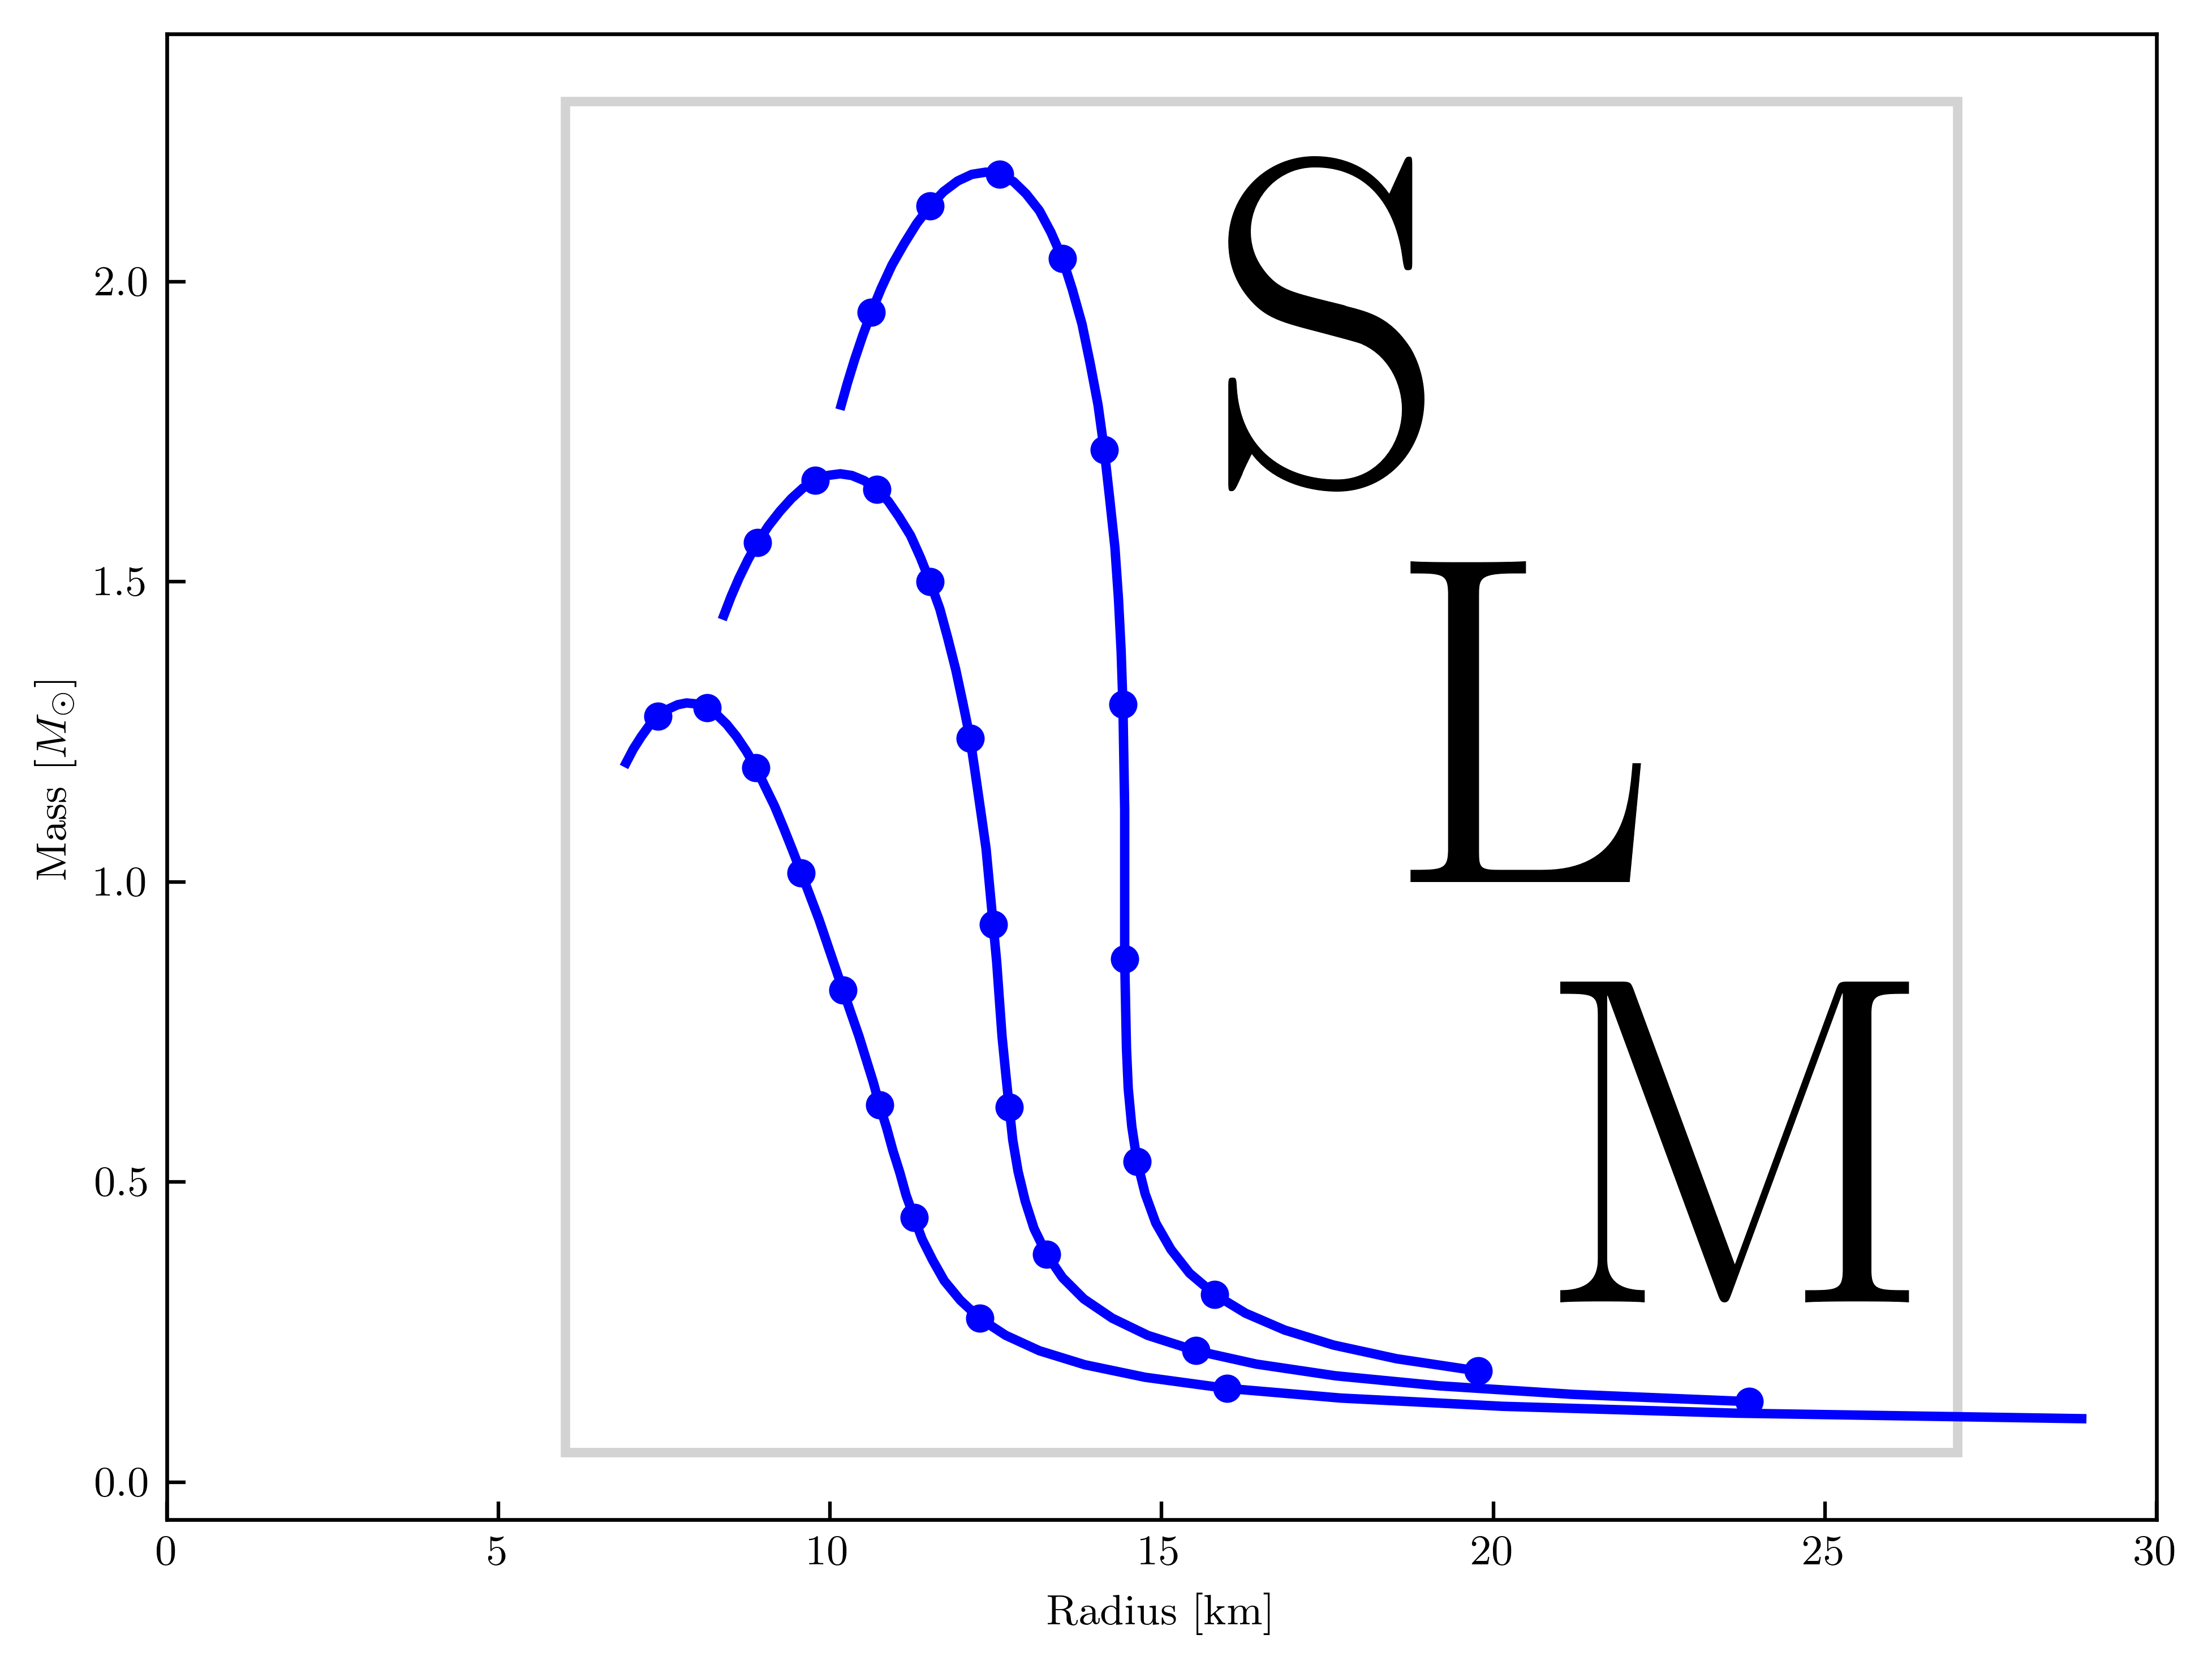

In [13]:
# draw rectangle behind it
import matplotlib.patches as patches

fig, ax = plt.subplots(dpi=600)

# Define the rectangle parameters
x = 6         # x-coordinate of the lower-left corner
y = 0.05         # y-coordinate of the lower-left corner
width = 21     # Width of the rectangle
height = 2.25    # Height of the rectangle

# Create a light grey rectangle and add it to the plot
rectangle = patches.Rectangle((x, y), width, height, linewidth=2,
                              edgecolor='lightgray', facecolor='white')
ax.add_patch(rectangle)

ax.plot(radius_data_mean_20[:,1], mass_data_mean_20[:,1], color='blue', linewidth=2)
ax.plot(radius_data_mean_20[::5,1], mass_data_mean_20[::5,1], '.', markersize=10, color='blue')
ax.plot(radius_data_mean_20[:,2], mass_data_mean_20[:,2], color='blue', linewidth=2)
ax.plot(radius_data_mean_20[::5,2], mass_data_mean_20[::5,2], '.', color='blue', markersize=10)
ax.plot(radius_data_mean_20[1:,0], mass_data_mean_20[1:,0], color='blue', linewidth=2)
ax.plot(radius_data_mean_20[::5,0], mass_data_mean_20[::5,0], '.', markersize=10, color='blue')

# make giant SLM letters
plt.text(16, 1.65, r'S', fontsize=100)
plt.text(18.75, 1.0, r'L', fontsize=100)
plt.text(21, 0.3, r'M', fontsize=100)

# plot some points 
ax.set_ylabel('Mass [$M_{\odot}$]')
ax.set_xlabel('Radius [km]')
ax.set_xlim(0.0, 30.0)
plt.show()

In [35]:
# run the maximum mass and radius for the arrays to save
m_rad, m_pres, m_mass = tov_mean_20.max_arrays()

# save the radii, pressures, and masses
#np.savez('rpm_results_stationary_20n0.npz', radius=radius_data, central_pressure=pressure_data, mass=mass_data, max_radius=m_rad, max_mass=m_mass)

In [39]:
# load the 40n0 results
with open('pres_data_40n0.pkl', 'rb') as fp:
    pressure_dict_40n0 = pickle.load(fp)  # automatically in order of saving
    edens_dict_40n0 = pickle.load(fp)
    cs2_dict_40n0 = pickle.load(fp)

EOFError: Ran out of input

In [16]:
# number of samples
# samples_40n0 = len(pressure_dict_40n0['samples'].T)

# # TOV data creation (streamlined)
# tov_dict_40n0 = tov_data(edens_dict_40n0, pressure_dict_40n0, save=True, \
#                     filepath='../data/TOV_data/eos_stationary_40n0.npz')

# # run the TOV solver over each sample
# mass_data_40n0 = np.zeros([50,samples_40n0])
# radius_data_40n0 = np.zeros([50,samples_40n0])
# pressure_data_40n0 = np.zeros([50,samples_40n0])

# # call the solver once, send all data directly
# tov40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_40n0.npz')

# # call routine once (should do its thing...check why central pressures are the same for different ones)
# radius_data_40n0, pressure_data_40n0, mass_data_40n0 = tov40.tov_routine(verbose=False, write_to_file=False)

In [17]:
# run the maximum mass and radius for the arrays to save
m_rad_40n0, m_pres_40n0, m_mass_40n0 = tov_mean_40.max_arrays()

# save the radii, pressures, and masses
# np.savez('rpm_results_stationary_40n0.npz', radius=radius_data_40n0, central_pressure=pressure_data_40n0, \
#          mass=mass_data_40n0, max_radius=m_rad_40n0, max_mass=m_mass_40n0)

In [18]:
# load the data for the overlay plot
stationary_20 = np.load('rpm_results_stationary_20n0.npz')
stationary_40 = np.load('rpm_results_stationary_40n0.npz')

# separate it all out
radius20n0 = stationary_20['radius']
cpres20n0 = stationary_20['central_pressure']
mass20n0 = stationary_20['mass']
maxrad20n0 = stationary_20['max_radius']
maxmass20n0 = stationary_20['max_mass']

radius40n0 = stationary_40['radius']
cpres40n0 = stationary_40['central_pressure']
mass40n0 = stationary_40['mass']
maxrad40n0 = stationary_40['max_radius']
maxmass40n0 = stationary_40['max_mass']

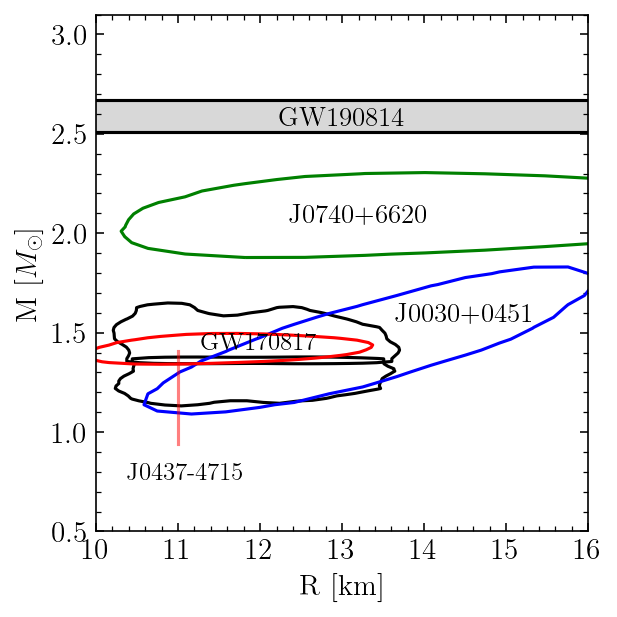

In [19]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='green', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='blue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
ax.text(13.2, 2.15, r'J0740+6620', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'J0030+0451', ha='center', va='top', fontsize=13)
# GW 190814
fake_linspace = np.linspace(10.0, 16.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.3, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(13.0, 2.635, r'GW190814', ha='center', va='top', fontsize=13)
ax.set_ylim(0.5,3.1)
ax.set_xlim(10.0,16.0)
# ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(right=True, top=True, which='both', labelsize=14)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r'R [km]', fontsize=14)
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=14)
ax.text(12.0, 1.5, r'GW170817', ha='center', va='top', fontsize=12)
ax.axvline(x=11.0, ymin=0.17, ymax=0.35, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'J0437-4715', ha='center', va='top', fontsize=12)
plt.show()
plt.show()

(0.0, 3.0)

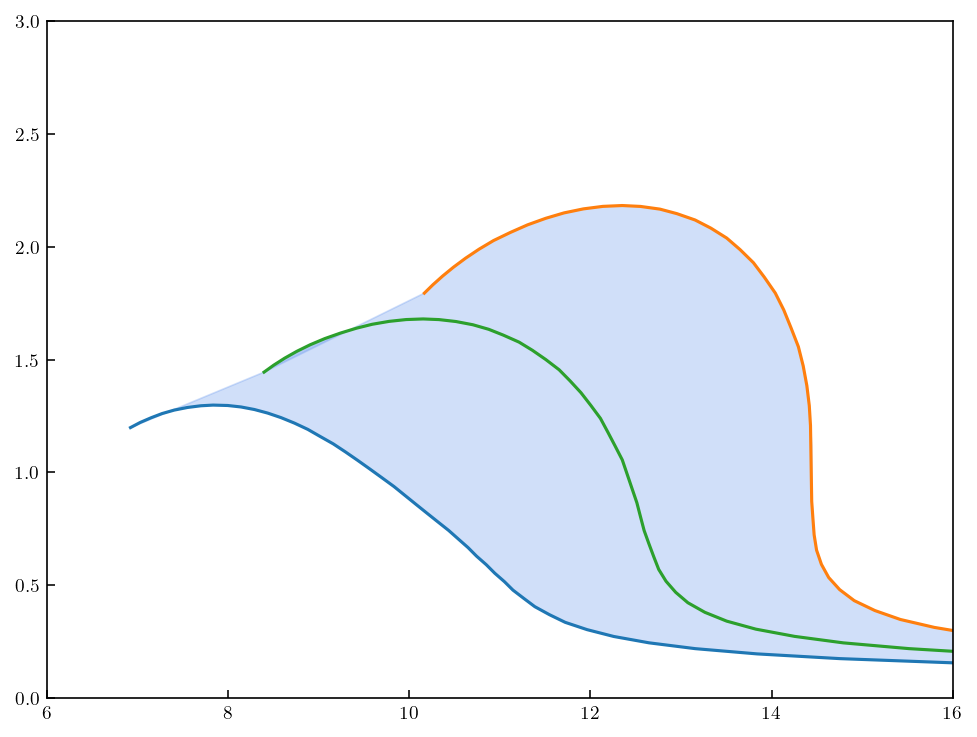

In [20]:
# interpolate the M-R curves and see if things happen
# reverse radius array
radius_copy = radius_data_mean_20[::-1]

mr_interp_20_mean = interp1d(radius_data_mean_20[:,1], mass_data_mean_20[:,1], \
                             kind='cubic', fill_value='extrapolate')
mr_interp_20_lower = interp1d(radius_data_mean_20[:,0], mass_data_mean_20[:,0], \
                             kind='cubic', fill_value='extrapolate')
mr_interp_20_upper = interp1d(radius_data_mean_20[:,2], mass_data_mean_20[:,2], \
                             kind='linear', fill_value='extrapolate')

# interpolate the M-R upper curve at the lower bound (this makes no sense right now)
index_mean_upper = np.where([radius_data_mean_20[-1,2] >= radius_data_mean_20[i,1] \
                for i in range(len(radius_data_mean_20))])[0][-1]

# radius of mean 1 and then interpolate from that point
interp_mean_at_higher_2 = mr_interp_20_mean(radius_data_mean_20[:index_mean_upper+1, 2])

# stitch these together and see
radius_full = radius_data_mean_20[:index_mean_upper+1, 2]
mass_full = interp_mean_at_higher_2

from matplotlib.patches import Polygon

# Define vertices for the region
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.3)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.3)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

# plt.plot(radius_data_mean_20[index_mean_upper:, 2], interp_mean_at_higher)
# plt.plot(radius_data_mean_20[:index_mean_upper+1, 2], interp_mean_at_higher_2)
#plt.fill_between(radius_full, mass_full, mr_interp_20_upper(radius_full))
plt.plot(radius_data_mean_20[:,0], mr_interp_20_lower(radius_data_mean_20[:,0]))
plt.plot(radius_data_mean_20[:,2], mr_interp_20_upper(radius_data_mean_20[:,2]))
plt.plot(radius_data_mean_20[:,1], mr_interp_20_mean(radius_data_mean_20[:,1]))
plt.xlim(6.0, 16.0)
plt.ylim(0.0, 3.0)

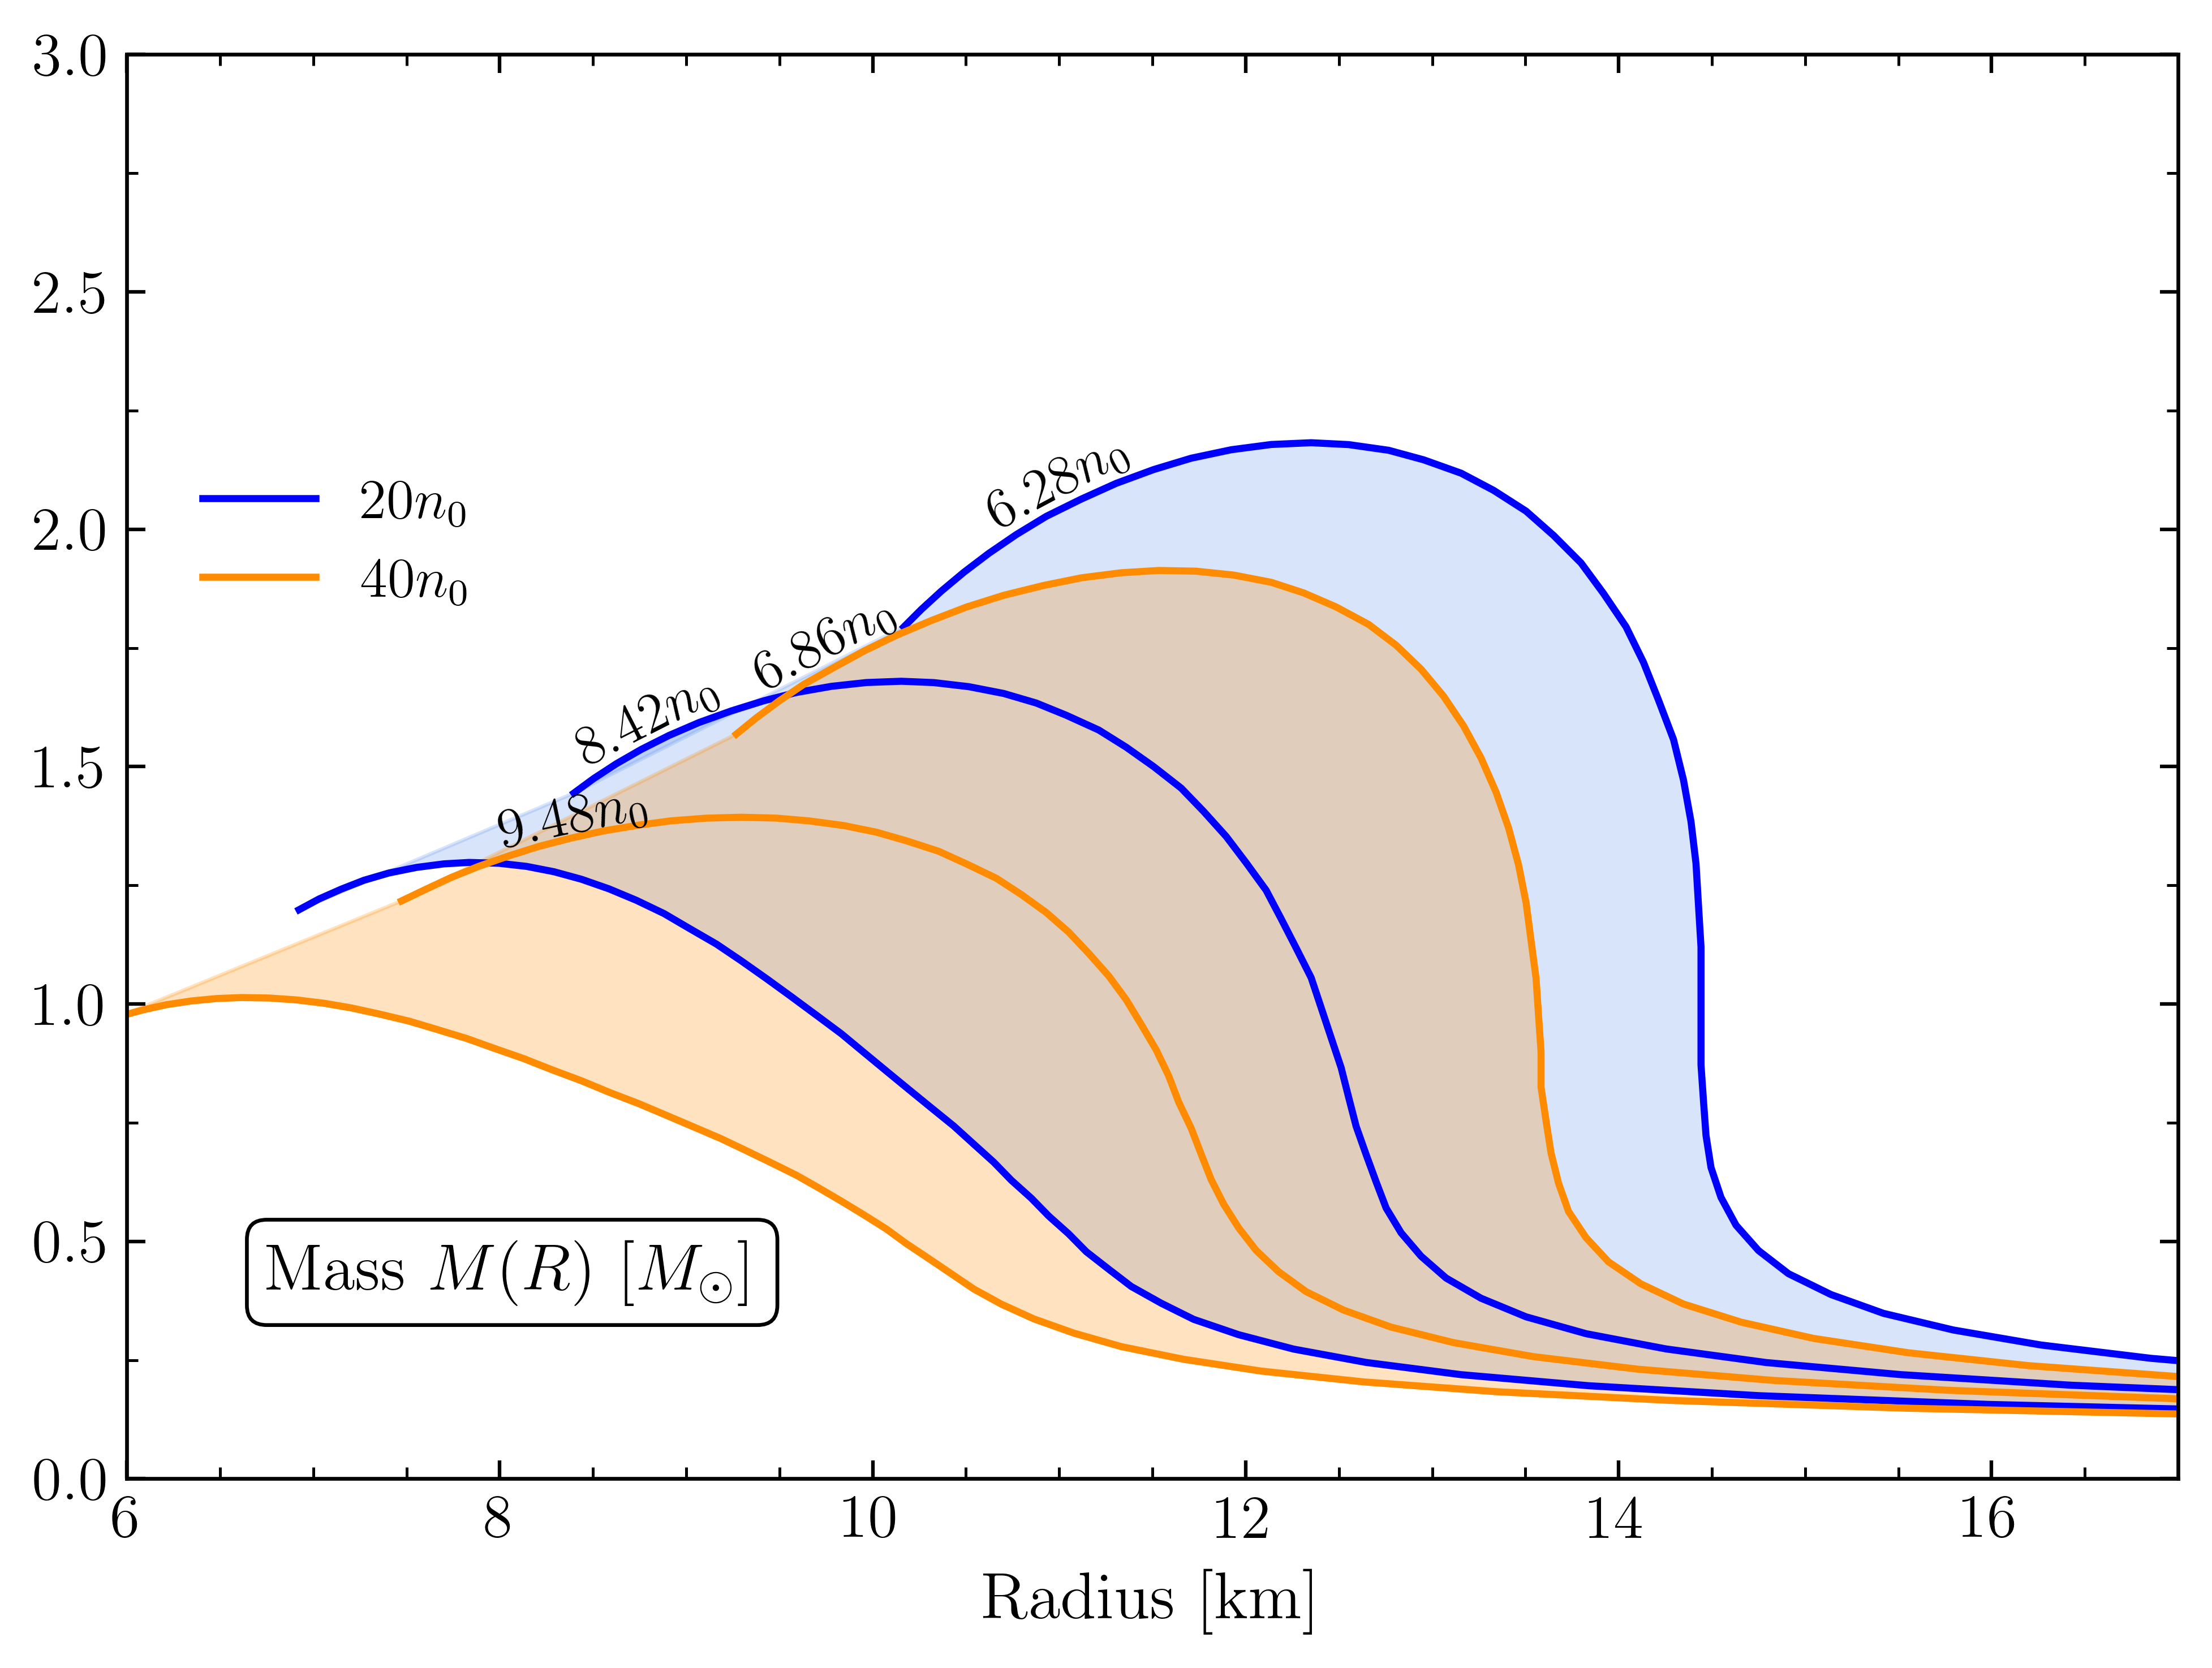

In [21]:
import matplotlib.patches as mpatches

# # define royal purple for contours
#royal_purple = '#9B30FF'

# plot the results including the samples and the overall mean, std_dev
fig, ax = plt.subplots(1,1, dpi=600)

# means
ax.plot(radius_data_mean_20, mass_data_mean_20, color='blue', label=r'$20n_{0}$')
ax.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange', label=r'$40n_{0}$')

# 20n0
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

# 40n0
vertices40 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,1], mass_data_mean_40[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,2]), reversed(mass_data_mean_40[:,2]))]
vertices402 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,0], mass_data_mean_40[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,1]), reversed(mass_data_mean_40[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

polygon40 = Polygon(vertices40, closed=True, color="darkorange", alpha=0.25)
polygon402 = Polygon(vertices402, closed=True, color="darkorange", alpha=0.25)
plt.gca().add_patch(polygon40)
plt.gca().add_patch(polygon402)

handles, labels = plt.gca().get_legend_handles_labels()

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=12, frameon=False, bbox_to_anchor=[0.2, 0.75])

# NICER and LIGO contours
# corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
#               levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
    
# labels for LIGO and NICER data
# ax.text(13.2, 2.15, r'$\textbf{J0740+6620}$', ha='center', va='top', fontsize=13)
# ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', ha='center', va='top', fontsize=13)

# # GW 190814
# fake_linspace = np.linspace(6.0, 17.0, 100)
# gw_lower = 2.51*np.ones(len(fake_linspace))
# gw_upper = 2.67*np.ones(len(fake_linspace))
# ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.25, color='grey', hatch='/')
# ax.axhline(y=2.51, color='lightgrey')
# ax.axhline(y=2.67, color='lightgrey')
# ax.text(11.5, 2.635, r'$\textbf{GW190814}$', ha='center', va='top', fontsize=13)
# ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=13, zorder=10)
# ax.axvline(x=11.0, ymin=0.30, ymax=0.475, color='red', alpha=0.5)
# ax.text(11.1, 0.85, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=13)

# adding labels for central densities of the top 2 curves
ax.text(8.4, 1.39, r'{:.2f}$n_0$'.format(cdens_mean_40[1]/n0), rotation=12, va='center', \
        ha='center', fontsize=12)
ax.text(9.75, 1.76, r'{:.2f}$n_0$'.format(cdens_mean_40[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.text(8.8, 1.6, r'{:.2f}$n_0$'.format(cdens_mean_20[1]/n0), rotation=27, va='center', \
        ha='center', fontsize=12)
ax.text(11.0, 2.1, r'{:.2f}$n_0$'.format(cdens_mean_20[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=13, right=True, top=True)
ax.tick_params(axis='both', which='minor', labelsize=13, right=True, top=True)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,3.0)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.40, r'Mass $M(R)$ $[M_\odot]$', fontsize=14, bbox=dict(facecolor='w', boxstyle='round'))
fig.savefig('basic_overlay_mr_curves.png')
plt.show()

# extract the contour, see if we can use it for the selection of curves!
# contour_collections = ax.collections
# contours = contour_collections[:2]

# vertices = []
# for contour in contours:
#     for path in contour.get_paths():
#         vertices.append(path.vertices)
        
# vertices_first = np.asarray(vertices)[0]

In [22]:
# write central densities
print(cdens_mean_20/n0)
print(cdens_mean_40/n0)

[12.87840579  8.41507544  6.27853489]
[17.37175092  9.47951654  6.85772183]
